In [40]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from sklearn.metrics.pairwise import haversine_distances
import math
from math import radians
import geopandas as gpd

from shapely.geometry import Point
from shapely import wkt
import contextily as ctx
from sklearn.neighbors import KernelDensity
import textwrap

In [41]:
survey = pd.read_csv('Students_OD_FromGIS - Anonym.csv',  encoding="windows-1252")
survey = survey.iloc[1:].reset_index(drop=True)
survey.columns



Index(['OBJECTID', 'StartDate', 'EndDate', 'Status', 'Progress',
       'Duration__in_seconds_', 'Finished', 'RecordedDate', 'ResponseId',
       'DistributionChannel', 'UserLanguage', 'Agreement', 'Question_1',
       'Question_2', 'Question_3', 'Question_3_7_TEXT', 'Question_4',
       'Question_5', 'Question_6', 'Question_8', 'Question_9',
       'Unique to School', 'Question_10', 'Question_10_7_TEXT', 'Question_11',
       'Question_11_6_TEXT', 'Question_12', 'Question_13', 'Question_14',
       'Question_15', 'Question_16', 'LocationY', 'LocationX', 'School_X',
       'School_Y', 'SortOrder', 'Total_TravelTime', 'Total_Kilometers',
       'Total_Miles', 'Bus/Bike/Walk Time'],
      dtype='object')

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\3667186608.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Reason', y='Count', data=reason_counts_q13, order=reason_counts_q13['Reason'], palette='pastel')


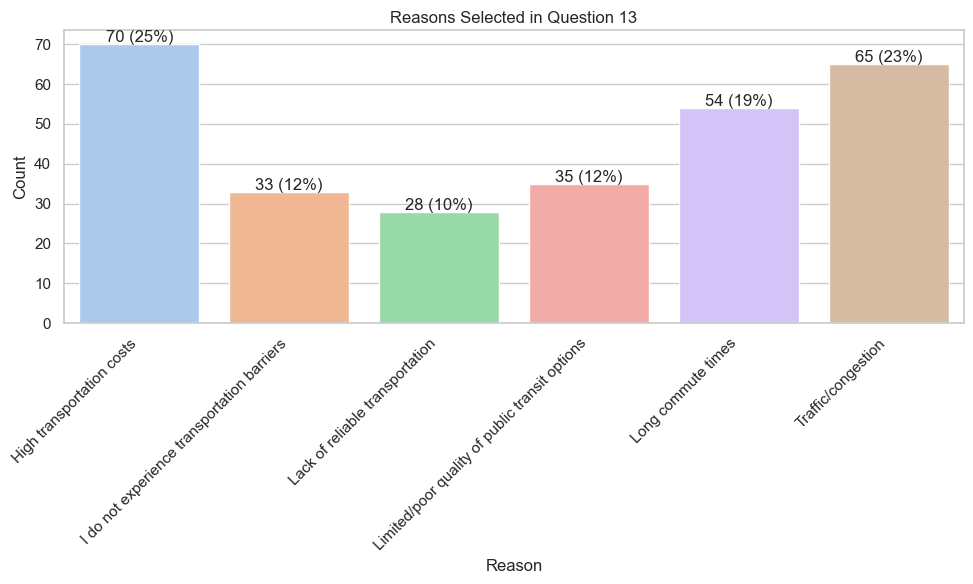

In [42]:
# Question 13 : Do you experience any of these transportation barriers? (Check all that apply)

# Split, explode, and clean up the responses
reasons_series_q13 = survey['Question_13'].dropna().str.split(',').explode().str.strip()

# Count occurrences of each response
reason_counts_q13 = reasons_series_q13.value_counts().reset_index()
reason_counts_q13.columns = ['Reason', 'Count']

# (Optional) Standardize 'Other: (please describe)' to 'Other'
reason_counts_q13['Reason'] = reason_counts_q13['Reason'].replace('Other: (please describe)', 'Other')
reason_counts_q13 = reason_counts_q13.groupby('Reason', as_index=False)['Count'].sum()

# Round counts to nearest whole number (for display)
reason_counts_q13['Count'] = reason_counts_q13['Count'].round().astype(int)

# Graph

total_reasons_q13 = reason_counts_q13['Count'].sum()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Reason', y='Count', data=reason_counts_q13, order=reason_counts_q13['Reason'], palette='pastel')

# Add count and percentage labels on top of each bar, both as integers
for p in ax.patches:
    height = int(round(p.get_height()))
    percentage = int(round((height / total_reasons_q13) * 100))
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.5,
        f'{height} ({percentage}%)',
        ha='center'
    )

plt.title('Reasons Selected in Question 13')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1153773899.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Barrier', y='Count', data=counts, palette=colors, ax=ax)
C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1153773899.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels)
C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1153773899.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Barrier', y='Count', data=counts, palette=colors, ax=ax)
C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1153773899.py:59: UserWarning: set_ticklabels() should only be used

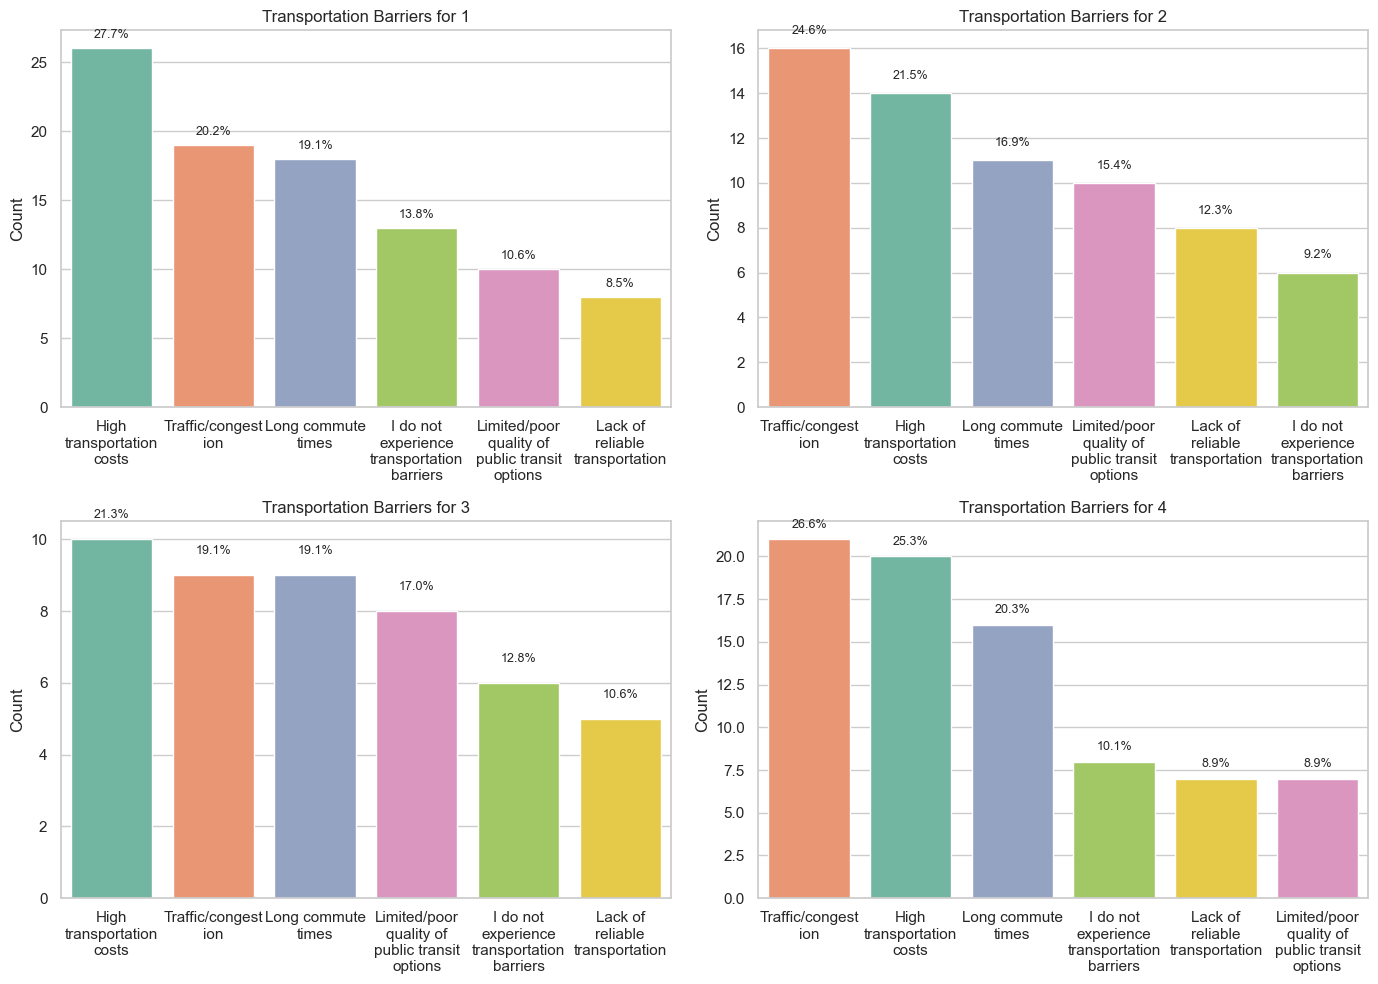

164

In [43]:
#Breaking down by College (Question_6)


# Drop rows with missing values in either column
survey_filtered = survey.dropna(subset=['Question_6', 'Question_13'])

# Get all individual responses for consistent color mapping
all_barriers = (
    survey_filtered['Question_13']
    .str.split(',')
    .explode()
    .str.strip()
    .value_counts()
    .index
    .tolist()
)

# Create a color palette for all barriers
color_palette = sns.color_palette("Set2", n_colors=len(all_barriers))
barrier_colors = dict(zip(all_barriers, color_palette))

# Get unique colleges
colleges = sorted(survey_filtered['Question_6'].dropna().unique())
n_cols = 2
n_rows = math.ceil(len(colleges) / n_cols)

# Set up the grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows), squeeze=False)

for idx, college in enumerate(colleges):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row][col]

    # Filter data for this college
    college_df = survey_filtered[survey_filtered['Question_6'] == college]
    exploded = college_df['Question_13'].str.split(',').explode().str.strip()

    # Count each barrier
    counts = exploded.value_counts().reset_index()
    counts.columns = ['Barrier', 'Count']
    total = counts['Count'].sum()

    # Apply color palette
    colors = [barrier_colors[b] for b in counts['Barrier']]

    sns.barplot(x='Barrier', y='Count', data=counts, palette=colors, ax=ax)

    ax.set_title(f'Transportation Barriers for {college}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=0)

    # ✅ Wrap long labels
    wrapped_labels = [
        '\n'.join(textwrap.wrap(label.get_text(), width=15))
        for label in ax.get_xticklabels()
    ]
    ax.set_xticklabels(wrapped_labels)

    # ✅ Add percentage labels above each bar
    for bar, count in zip(ax.patches, counts['Count']):
        height = bar.get_height()
        percent = f"{(count / total) * 100:.1f}%"
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            percent,
            ha='center',
            va='bottom',
            fontsize=9
        )

# Remove any empty subplots
for i in range(len(colleges), n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

plt.tight_layout()
plt.show()

len(survey_filtered)

Generally, high transportation costs and traffic/congestion are always the 

High Transportation costs from college 1 due to transit as well as PARKING; School 3 too possibly bc of transit
schools 2 and 4 both have Traffic/congestion as the highest (potentially more drivers)


C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\4177944293.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


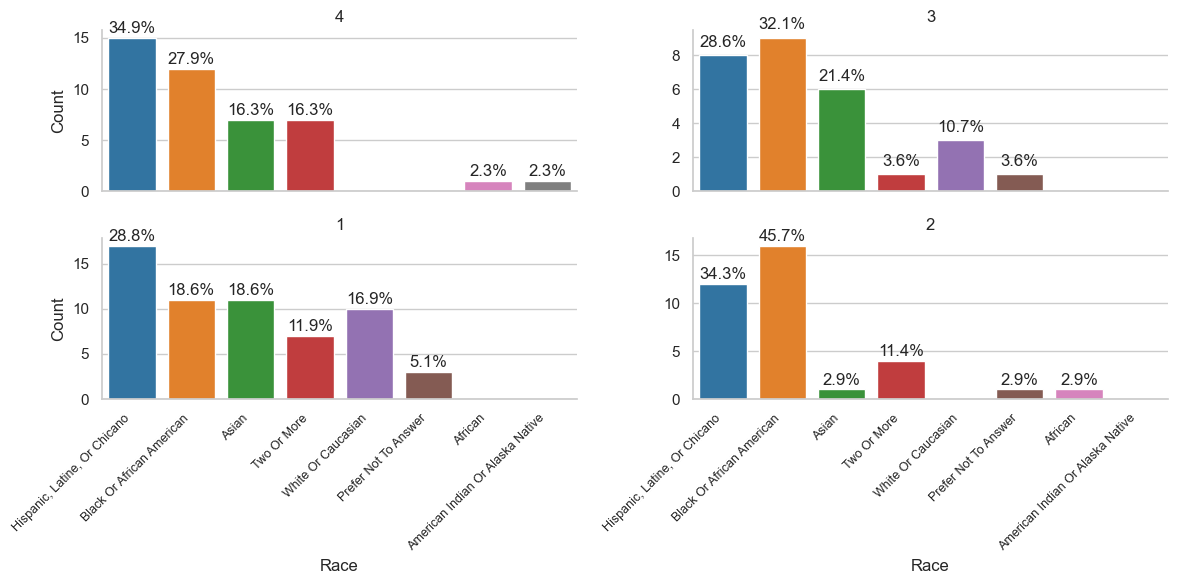

165

In [44]:
# Replace custom self-described responses
mask = survey["Question_3"] == "Prefer to Self Describe:"
survey.loc[mask, "Question_3"] = survey.loc[mask, "Question_3_7_TEXT"]

# Combine multiple race responses into "Two or More"
survey.loc[survey["Question_3"].str.contains(",", na=False), "Question_3"] = "Two or More"

# Standardize some race values
survey['Question_3'] = survey['Question_3'].replace({
    'Ethiopia ': 'African',
    'North african': 'African',
    "I’m a mix between a Mexican and American ": 'Hispanic, Latine, or Chicano',
    'Chicano ': 'Hispanic, Latine, or Chicano',
    'Hispanic or Latine': 'Hispanic, Latine, or Chicano',
    'Latin American indigenous': 'Two or More'
})

# Drop rows missing race or college
survey_filtered = survey.dropna(subset=['Question_3', 'Question_6']).copy()

# Handle multiple races (if any left after your replacement)
#survey_filtered['Question_3'] = survey_filtered['Question_3'].str.split(',')
survey_exploded = survey_filtered.explode('Question_3')

# Clean whitespace and standardize case
survey_exploded['Question_3'] = survey_exploded['Question_3'].str.strip().str.title()

# ---------------------------
# PLOTTING SETUP
# ---------------------------

# Top 4 colleges by response count
top_colleges = survey_exploded['Question_6'].value_counts().nlargest(4).index
survey_subset = survey_exploded[survey_exploded['Question_6'].isin(top_colleges)].copy()

# Get race categories in order of frequency
race_order = survey_subset['Question_3'].value_counts().index.drop_duplicates()

# Generate color palette
races = race_order.tolist()
race_colors = sns.color_palette("tab10", n_colors=len(races))
race_palette = dict(zip(races, race_colors))

# ---------------------------
# PLOTTING
# ---------------------------

# Define race order explicitly from the data
race_order = survey_subset['Question_3'].value_counts().index.drop_duplicates().tolist()

# Create the plot
# Reset index before plotting
survey_subset = survey_subset.reset_index(drop=True)

# (Rest of your plotting code remains the same)
sns.set(style="whitegrid")
g = sns.catplot(
    data=survey_subset,
    x='Question_3', kind='count', col='Question_6',
    col_wrap=2, sharey=False,
    order=race_order,
    palette=race_palette
)

# Add percentage labels, etc.
for ax in g.axes.flatten():
    total = sum([p.get_height() for p in ax.patches])
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2., height + 0.5,
                f'{(height / total * 100):.1f}%', ha="center"
            )


# Set x-axis labels manually from race_order
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Race", "Count")

for ax in g.axes.flatten():
    ax.set_xticks(range(len(race_order)))
    ax.set_xticklabels(race_order, rotation=45, ha='right', fontsize=9)

# Resize figure
g.fig.set_size_inches(12, 6)
plt.tight_layout()
plt.show()

len(survey_filtered)

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\2396315471.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=survey_subset, x='Question_3', y='tt', ci='sd', palette = "Set2")  # ci='sd' adds error bars
C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\2396315471.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=survey_subset, x='Question_3', y='tt', ci='sd', palette = "Set2")  # ci='sd' adds error bars


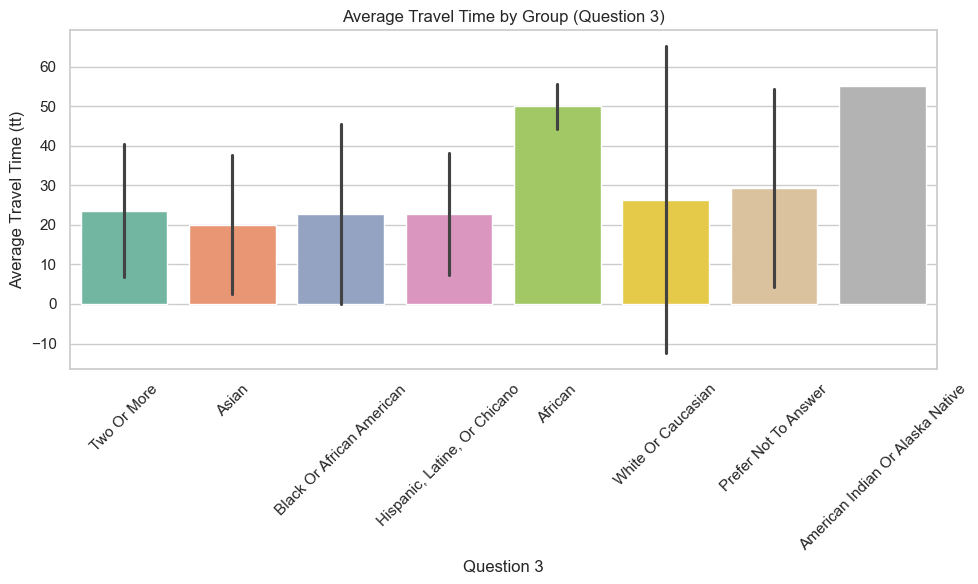

In [45]:
def choose_tt(row):
    if row['Question_12'] in ['Public transit (bus/BART)', 'Walk/bike/scooter']:
        if pd.notna(row['Bus/Bike/Walk Time']):
            return row['Bus/Bike/Walk Time']
        else:
            return row['Total_TravelTime']
    else:
        return row['Total_TravelTime']

survey_subset['tt'] = survey_subset.apply(choose_tt, axis=1)

plt.figure(figsize=(10, 6))
sns.barplot(data=survey_subset, x='Question_3', y='tt', ci='sd', palette = "Set2")  # ci='sd' adds error bars

plt.xlabel('Question 3')
plt.ylabel('Average Travel Time (tt)')
plt.title('Average Travel Time by Group (Question 3)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1243962761.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=survey_subset, x='Question_3', y='tt', palette = "Set2")


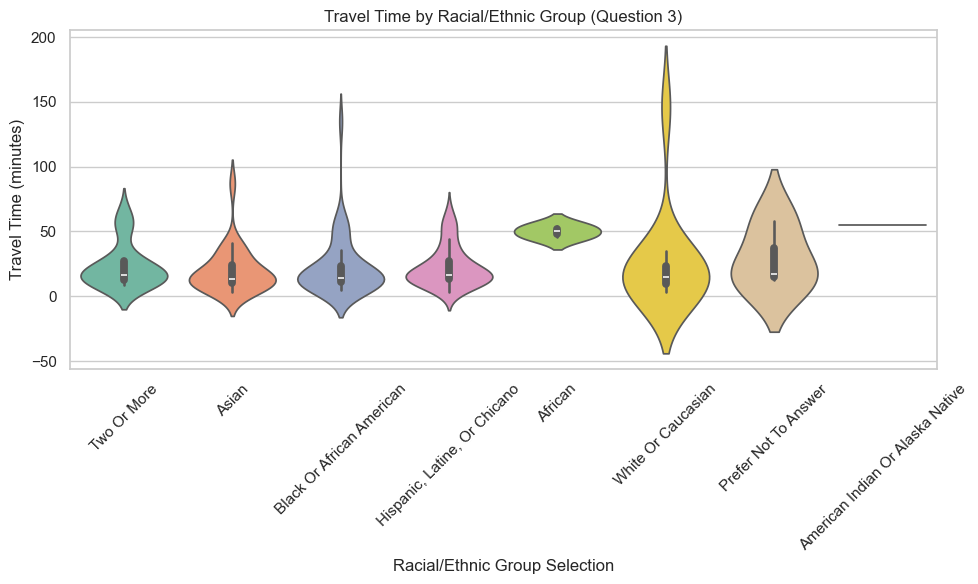

166

In [46]:
# Set the plot style
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.violinplot(data=survey_subset, x='Question_3', y='tt', palette = "Set2")

# Add labels and title
plt.xlabel('Racial/Ethnic Group Selection')
plt.ylabel('Travel Time (minutes)')
plt.title('Travel Time by Racial/Ethnic Group (Question 3)')
plt.xticks(rotation=45)  # Rotate labels if they overlap

plt.tight_layout()
plt.show()
len(survey)

In [47]:
survey_subset.dropna(subset = ['tt'])
len(survey_subset)

165

In [48]:
from scipy.stats import shapiro


# Shapiro-Wilk test of normality
# Loop through each ethnic group
for name, group in survey_subset.groupby('Question_3'):
    tt_values = group['tt'].dropna()
    
    if len(tt_values) >= 3 and len(set(tt_values)) > 1:  # Shapiro needs ≥3 and some variance
        stat, p = shapiro(tt_values)
        print(f"{name}: p = {p:.4f} {'(Normal)' if p > 0.05 else '(Not normal)'}")
    else:
        print(f"{name}: Not enough data or no variance to test normality.")


African: Not enough data or no variance to test normality.
American Indian Or Alaska Native: Not enough data or no variance to test normality.
Asian: p = 0.0000 (Not normal)
Black Or African American: p = 0.0000 (Not normal)
Hispanic, Latine, Or Chicano: p = 0.0001 (Not normal)
Prefer Not To Answer: p = 0.1764 (Normal)
Two Or More: p = 0.0004 (Not normal)
White Or Caucasian: p = 0.0000 (Not normal)


In [49]:
# Use Kruskal-Wallis bc of lack of normality
from scipy.stats import kruskal


# Group travel times by race (drop NaNs and small groups)
valid_groups = [
    group['tt'].dropna()
    for name, group in survey_subset.groupby('Question_3')
    if len(group['tt'].dropna()) >= 3 and len(set(group['tt'].dropna())) > 1
]

# Run Kruskal-Wallis test
if len(valid_groups) >= 2:
    stat, p = kruskal(*valid_groups)
    print(f"Kruskal-Wallis test result: H = {stat:.3f}, p = {p:.4f}")
    if p < 0.05:
        print("➡️ Significant difference in travel times between at least one group (p < 0.05).")
    else:
        print("➡️ No significant difference in travel times between groups (p ≥ 0.05).")
else:
    print("❌ Not enough valid groups to perform the Kruskal-Wallis test.")



Kruskal-Wallis test result: H = 3.751, p = 0.5858
➡️ No significant difference in travel times between groups (p ≥ 0.05).


It does not seem that there are any racial differences in travel times, even when accounting for public transit and walking travel times

In [50]:
from scipy.stats import kruskal
import scikit_posthocs as sp


C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1719894645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_clean['Question_4_label'] = survey_clean['Question_4'].apply(
C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1719894645.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Question_4_label', y='tt', data=survey_clean, palette='Set2')


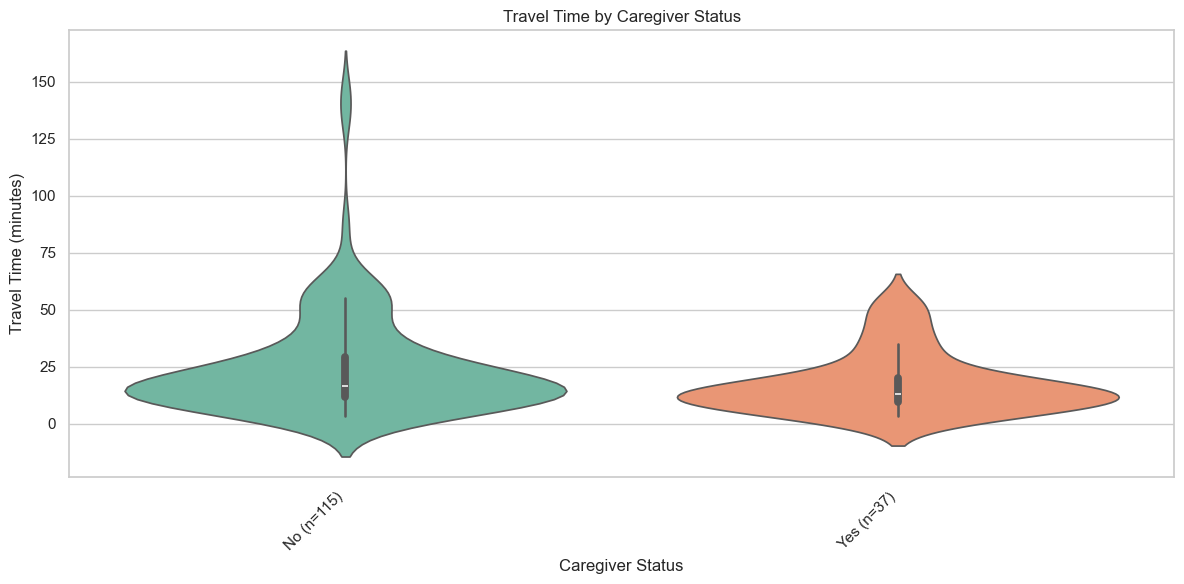

In [51]:
# Now lets look at caregivers status
survey['tt'] = survey.apply(choose_tt, axis=1)

# Drop rows with missing values
survey_clean = survey.dropna(subset=['Question_4', 'tt'])
counts = survey_clean['Question_4'].value_counts()
survey_clean['Question_4_label'] = survey_clean['Question_4'].apply(
    lambda x: f"{x} (n={counts[x]})"
)

# Set plot style
sns.set(style="whitegrid")

# Create boxplot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Question_4_label', y='tt', data=survey_clean, palette='Set2')

# Customize plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('Caregiver Status')
plt.ylabel('Travel Time (minutes)')
plt.title('Travel Time by Caregiver Status')
plt.tight_layout()

# Show plot
plt.show()


In [52]:
# Drop missing values
survey_clean = survey.dropna(subset=['Question_4', 'tt'])

# Group travel times by caregiver status
groups = [
    group['tt'].values
    for name, group in survey_clean.groupby('Question_4')
]

# Run Kruskal-Wallis test
stat, p = kruskal(*groups)

# Print result
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.4f}")

if p < 0.05:
    print("→ Significant difference in travel time by caregiver status (p < 0.05)")
else:
    print("→ No significant difference in travel time by caregiver status (p ≥ 0.05)")

# Make sure to drop missing values
survey_clean = survey.dropna(subset=['Question_4', 'tt'])

# Dunn's test (non-parametric post-hoc)
dunn_result = sp.posthoc_dunn(
    survey_clean, 
    val_col='tt', 
    group_col='Question_4', 
    p_adjust='bonferroni'  # You can also try 'holm', 'fdr_bh', etc.
)

# Display result
print('Dunn test result')
print(dunn_result)

# Group median travel times
medians = survey.groupby('Question_4')['tt'].median()
print("Median travel time by caregiver status:")
print(medians)

# Optional: also check means
means = survey.groupby('Question_4')['tt'].mean()
print("\nMean travel time by caregiver status:")
print(means)


Kruskal-Wallis H-statistic = 4.526, p-value = 0.0334
→ Significant difference in travel time by caregiver status (p < 0.05)
Dunn test result
          No      Yes
No   1.00000  0.03338
Yes  0.03338  1.00000
Median travel time by caregiver status:
Question_4
No     16.5
Yes    13.1
Name: tt, dtype: float64

Mean travel time by caregiver status:
Question_4
No     25.062609
Yes    17.643243
Name: tt, dtype: float64


Statistically, non-caregivers have a larger travel time than caregivers, possibly becuase it is more likely for a caregiver to have a car (need reference for this statement)


In [53]:
from scipy.stats import chi2_contingency

# Drop rows with missing values in either relevant column
survey_cleaned = survey.dropna(subset=['Question_4', 'Question_12'])

# Create a contingency table
contingency_table = pd.crosstab(survey_cleaned['Question_4'], survey_cleaned['Question_12'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output results
print("Chi-square test statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)

# Optional: print contingency table
print("\nContingency Table:")
print(contingency_table)


Chi-square test statistic: 5.56209198640491
Degrees of freedom: 4
p-value: 0.23432521892473676

Contingency Table:
Question_12  Carpool  Personal car  Public transit (bus/BART)  \
Question_4                                                      
No                 3            55                         54   
Yes                1            19                          8   

Question_12  Rideshare (Uber/Lyft)  Walk/bike/scooter  
Question_4                                             
No                               3                 13  
Yes                              2                  6  


In [54]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# Drop rows with missing values
survey_cleaned = survey.dropna(subset=['Question_4', 'Question_12'])

# Create a binary column for "Personal car"
survey_cleaned['personal_car'] = survey_cleaned['Question_12'] == 'Personal car'

# Count caregivers and non-caregivers
caregiver_mask = survey_cleaned['Question_4'] == 'Yes'  # adjust if your caregiver flag is different

# Success counts: number of "Personal car" in each group
count = [
    survey_cleaned[caregiver_mask]['personal_car'].sum(),
    survey_cleaned[~caregiver_mask]['personal_car'].sum()
]

# Total observations in each group
nobs = [
    caregiver_mask.sum(),
    (~caregiver_mask).sum()
]

# Perform two-proportion z-test
stat, pval = proportions_ztest(count, nobs)

# Output results
print("Z-test statistic:", stat)
print("p-value:", pval)


Z-test statistic: 1.0448814257419485
p-value: 0.29607777540425395


C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\2792122380.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_cleaned['personal_car'] = survey_cleaned['Question_12'] == 'Personal car'


C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\937427923.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Question_2', y='tt', data=survey_clean, palette='pastel')


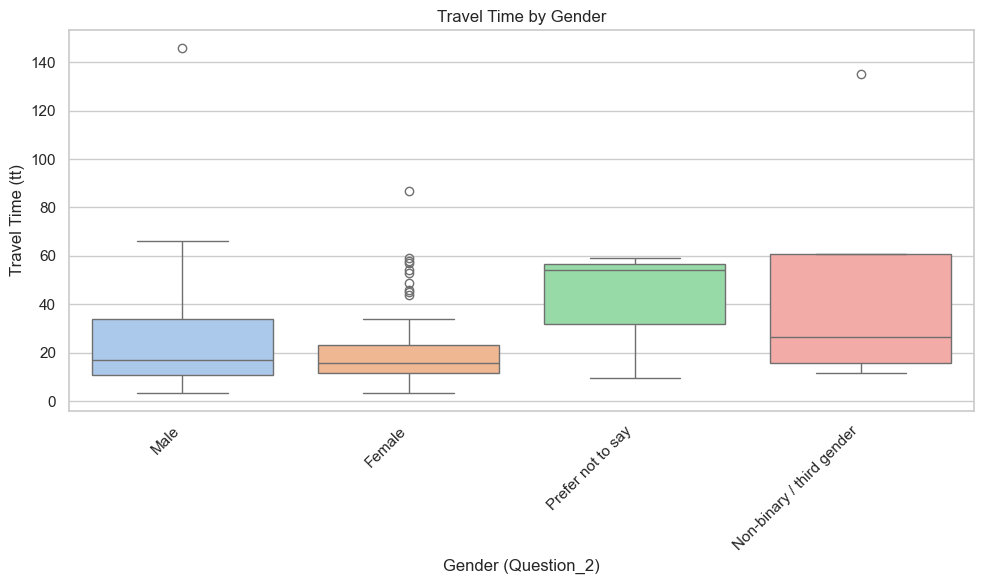

In [55]:
# Gender

# Drop missing values
survey_clean = survey.dropna(subset=['Question_2', 'tt'])

# Set style
sns.set(style="whitegrid")

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Question_2', y='tt', data=survey_clean, palette='pastel')

# Customize plot
plt.xlabel('Gender (Question_2)')
plt.ylabel('Travel Time (tt)')
plt.title('Travel Time by Gender')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()

In [56]:


# Drop missing values
survey_clean = survey.dropna(subset=['Question_2', 'tt'])

# Group travel times by gender
groups = [
    group['tt'].values
    for name, group in survey_clean.groupby('Question_2')
]

# Run Kruskal-Wallis H-test
stat, p = kruskal(*groups)

# Print results
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.4f}")

if p < 0.05:
    print("→ Statistically significant difference in travel time across gender groups (p < 0.05)")
elif p < 0.10:
    print("→ Moderate evidence of a difference (p < 0.10)")
else:
    print("→ No significant difference in travel time across gender groups (p ≥ 0.10)")

print("Now by School")
from scipy.stats import kruskal

# Drop missing values
survey_clean = survey.dropna(subset=['Question_2', 'tt', 'Question_6'])

# Get unique schools
schools = survey_clean['Question_6'].unique()

# Loop through each school and run the test
for school in schools:
    subset = survey_clean[survey_clean['Question_6'] == school]

    # Group travel times by gender
    groups = [
        group['tt'].values
        for _, group in subset.groupby('Question_2')
        if len(group) > 1  # ensure enough data for test
    ]
    
    # Only run test if 2+ groups have values
    if len(groups) >= 2:
        stat, p = kruskal(*groups)
        print(f"📍 School: {school}")
        print(f"  Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.4f}")
        if p < 0.05:
            print("  → Statistically significant difference in travel time across gender groups (p < 0.05)")
        elif p < 0.10:
            print("  → Moderate evidence of a difference (p < 0.10)")
        else:
            print("  → No significant difference (p ≥ 0.10)")
        print("-" * 60)
    else:
        print(f"📍 School: {school}")
        print("  Not enough groups with data to run Kruskal-Wallis test.")
        print("-" * 60)

        

Kruskal-Wallis H-statistic = 2.972, p-value = 0.3960
→ No significant difference in travel time across gender groups (p ≥ 0.10)
Now by School
📍 School: 4
  Kruskal-Wallis H-statistic = 5.236, p-value = 0.0730
  → Moderate evidence of a difference (p < 0.10)
------------------------------------------------------------
📍 School: 3
  Kruskal-Wallis H-statistic = 1.072, p-value = 0.5850
  → No significant difference (p ≥ 0.10)
------------------------------------------------------------
📍 School: 1
  Kruskal-Wallis H-statistic = 1.034, p-value = 0.5963
  → No significant difference (p ≥ 0.10)
------------------------------------------------------------
📍 School: 2
  Kruskal-Wallis H-statistic = 0.003, p-value = 0.9569
  → No significant difference (p ≥ 0.10)
------------------------------------------------------------


C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1571105682.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=survey_clean, x='Question_2', y='tt', palette='pastel', inner='box')


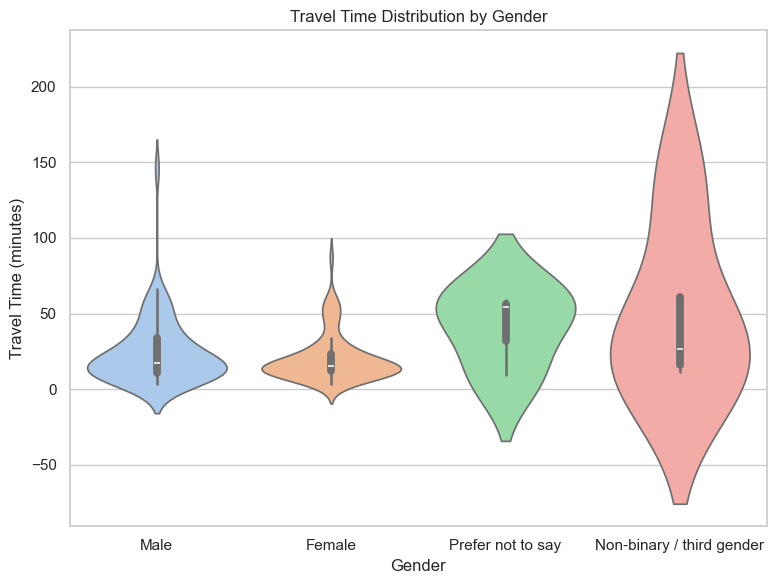

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop missing values for relevant columns
survey_clean = survey.dropna(subset=['tt', 'Question_2'])

# Create violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=survey_clean, x='Question_2', y='tt', palette='pastel', inner='box')

plt.title('Travel Time Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Travel Time (minutes)')
plt.tight_layout()
plt.show()


**Breaking down by College**

In [58]:
survey_subset['Question_3'].unique()

array(['Two Or More', 'Asian', 'Black Or African American',
       'Hispanic, Latine, Or Chicano', 'African', 'White Or Caucasian',
       'Prefer Not To Answer', 'American Indian Or Alaska Native'],
      dtype=object)

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\2860669510.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=s1, x='Question_3', y='tt', palette = race_palette)


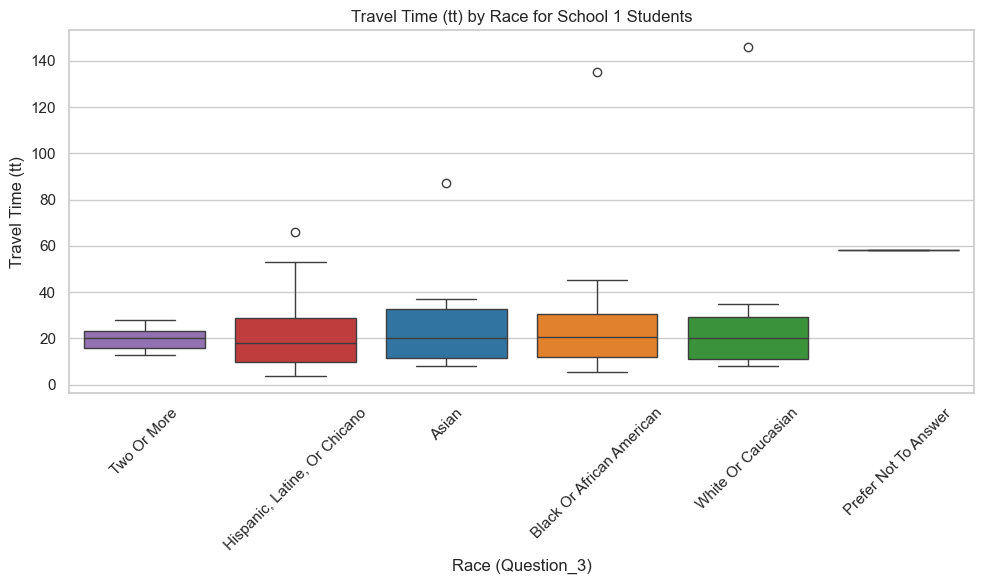

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\2860669510.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=s2, x='Question_3', y='tt', palette = race_palette)


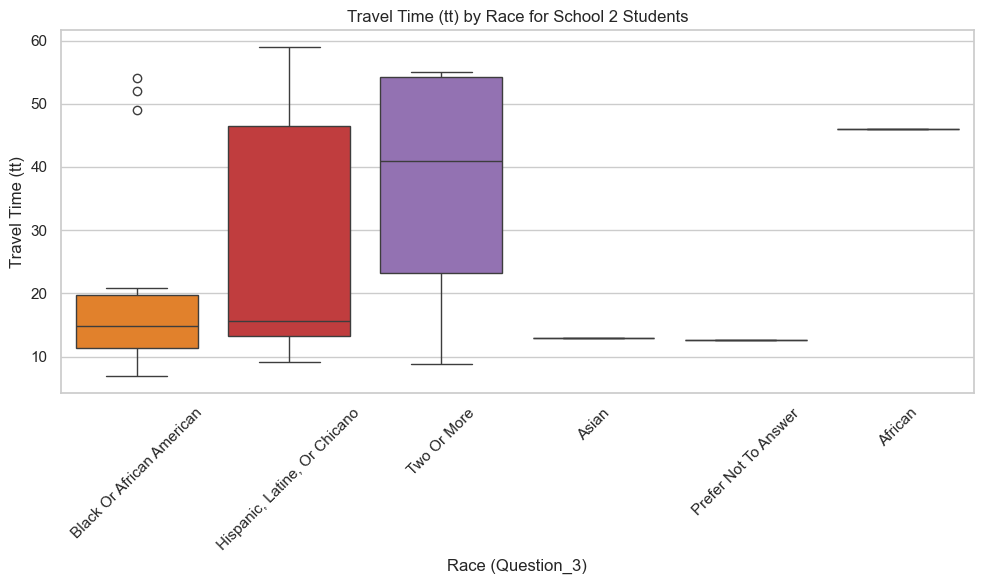

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\2860669510.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=s3, x='Question_3', y='tt', palette = race_palette)


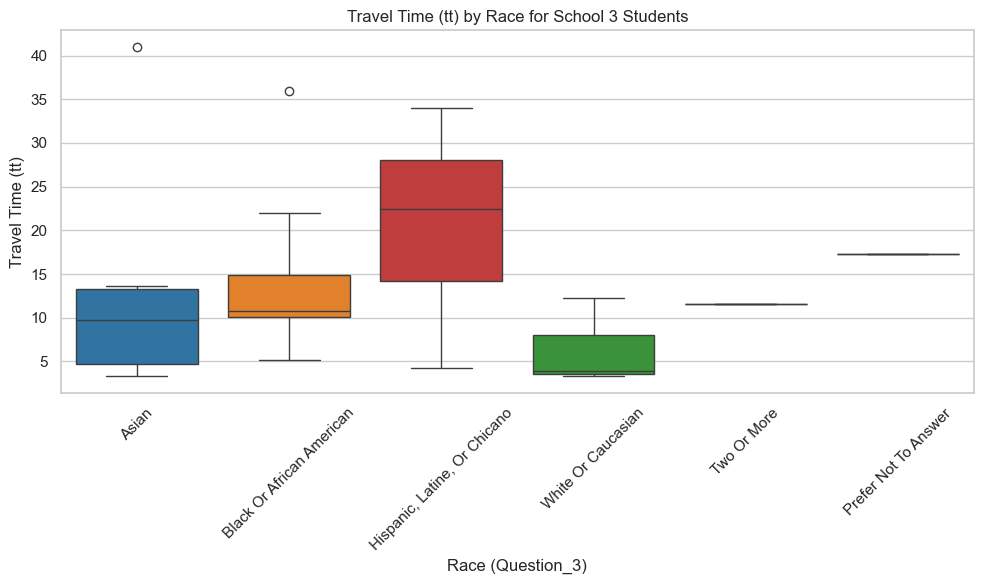

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\2860669510.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=s4, x='Question_3', y='tt', palette = race_palette)


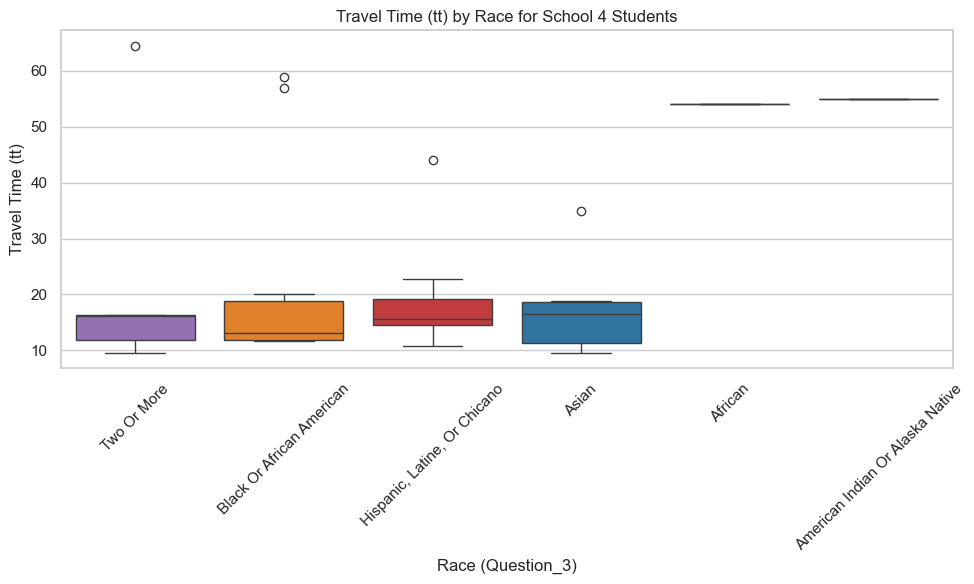

In [98]:
#Now lets just break this down by college

#clean_survey['tt'] = survey.apply(choose_tt, axis=1)

s1 = survey_subset[survey_subset['Question_6'] == '1']
s2 = survey_subset[survey_subset['Question_6'] == '2']
s3 = survey_subset[survey_subset['Question_6'] == '3']
s4 = survey_subset[survey_subset['Question_6'] == '4']



#Total 142 gave their location

race_palette = {
    
    'Asian': '#1f77b4',  # blue
    'Black Or African American': '#ff7f0e',  # orange
    'White Or Caucasian' : '#2ca02c',  # green
    'Hispanic, Latine, Or Chicano': '#d62728',  # red
    'Two Or More': '#9467bd',  # purple
    'American Indian Or Alaska Native': '#8c564b',  # brown
    'Prefer Not To Answer': '#e377c2',  # pink
    'African': '#7f7f7f'  # gray
}

selected = survey[['Question_6', 'Question_12',  'Total_TravelTime', 'Bus/Bike/Walk Time', 'tt']]

plt.figure(figsize=(10, 6))
sns.boxplot(data=s1, x='Question_3', y='tt', palette = race_palette)

plt.title('Travel Time (tt) by Race for School 1 Students')
plt.xlabel('Race (Question_3)')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##############
plt.figure(figsize=(10, 6))
sns.boxplot(data=s2, x='Question_3', y='tt', palette = race_palette)

plt.title('Travel Time (tt) by Race for School 2 Students')
plt.xlabel('Race (Question_3)')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############
plt.figure(figsize=(10, 6))
sns.boxplot(data=s3, x='Question_3', y='tt', palette = race_palette)

plt.title('Travel Time (tt) by Race for School 3 Students')
plt.xlabel('Race (Question_3)')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##############
plt.figure(figsize=(10, 6))
sns.boxplot(data=s4, x='Question_3', y='tt', palette = race_palette)

plt.title('Travel Time (tt) by Race for School 4 Students')
plt.xlabel('Race (Question_3)')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [90]:
from scipy.stats import kruskal

def run_kruskal_by_race(df, college_name):
    # Drop NaNs in 'tt'
    df = df.dropna(subset=['tt', 'Question_3'])

    # Group by race, get list of 'tt' values
    groups = [group['tt'].values for name, group in df.groupby('Question_3') if group['tt'].count() >= 2]

    # Check if we have at least 2 groups to compare
    if len(groups) >= 2:
        stat, p = kruskal(*groups)
        print(f"Kruskal-Wallis for {college_name}: H-statistic={stat:.3f}, p-value={p:.4f}")
    else:
        print(f"Not enough valid groups for Kruskal-Wallis test at {college_name}")

# Run for each college
run_kruskal_by_race(s1, "School 1")
run_kruskal_by_race(s2, "School 2")
run_kruskal_by_race(s3, "School 3")
run_kruskal_by_race(s4, "School 4")


Kruskal-Wallis for School 1: H-statistic=0.326, p-value=0.9881
Kruskal-Wallis for School 2: H-statistic=2.317, p-value=0.3139
Kruskal-Wallis for School 3: H-statistic=5.865, p-value=0.1184
Kruskal-Wallis for School 4: H-statistic=0.533, p-value=0.9115


From the Kruskal-Wallis tests, the travel time does not vary by race in a significant way, even when broken down by school

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\3749549249.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=s1, x='Question_4', y='tt', palette = 'Set2')


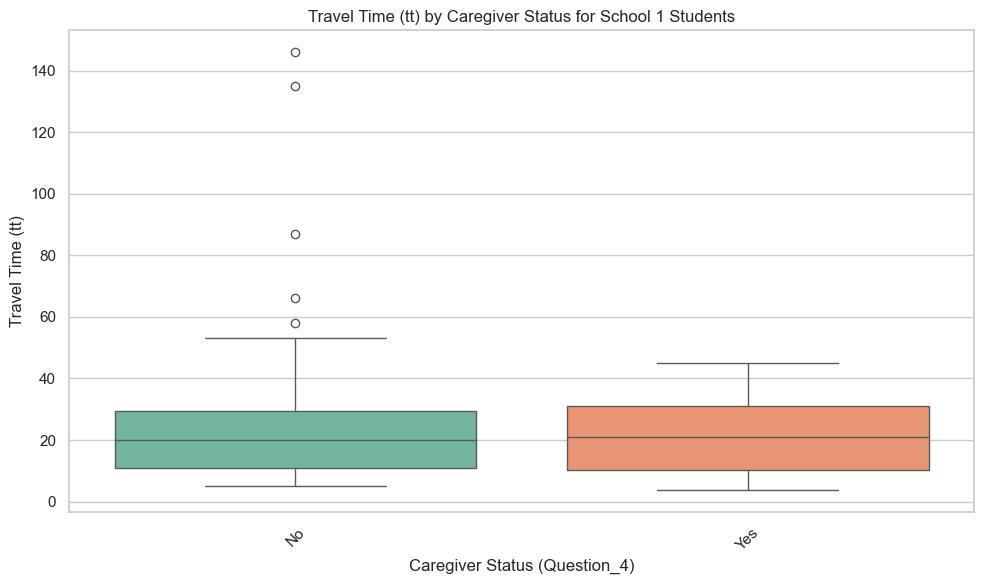

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\3749549249.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=s2, x='Question_4', y='tt', palette = 'Set2')


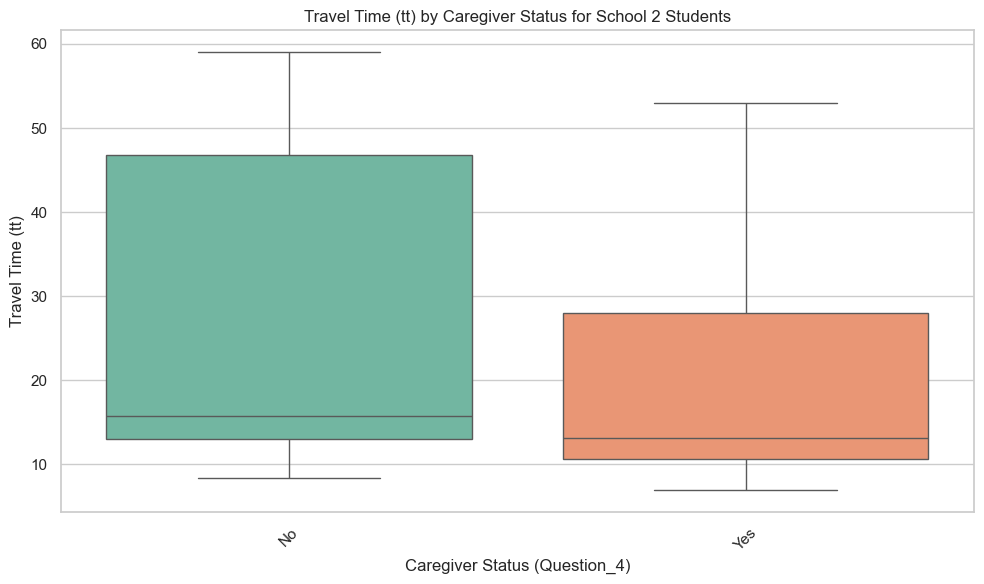

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\3749549249.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=s3, x='Question_4', y='tt', palette = 'Set2')


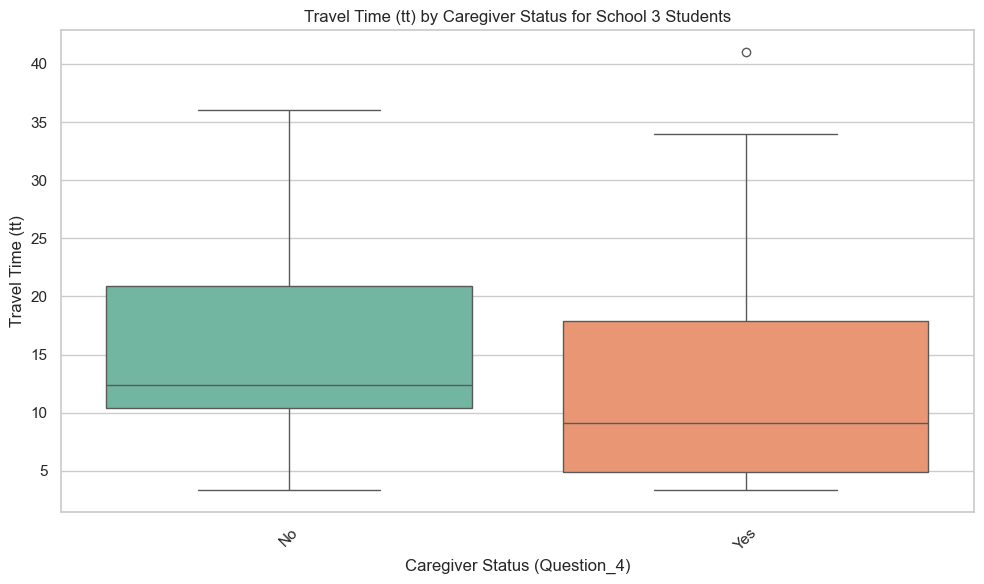

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\3749549249.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=s4, x='Question_4', y='tt', palette = 'Set2')


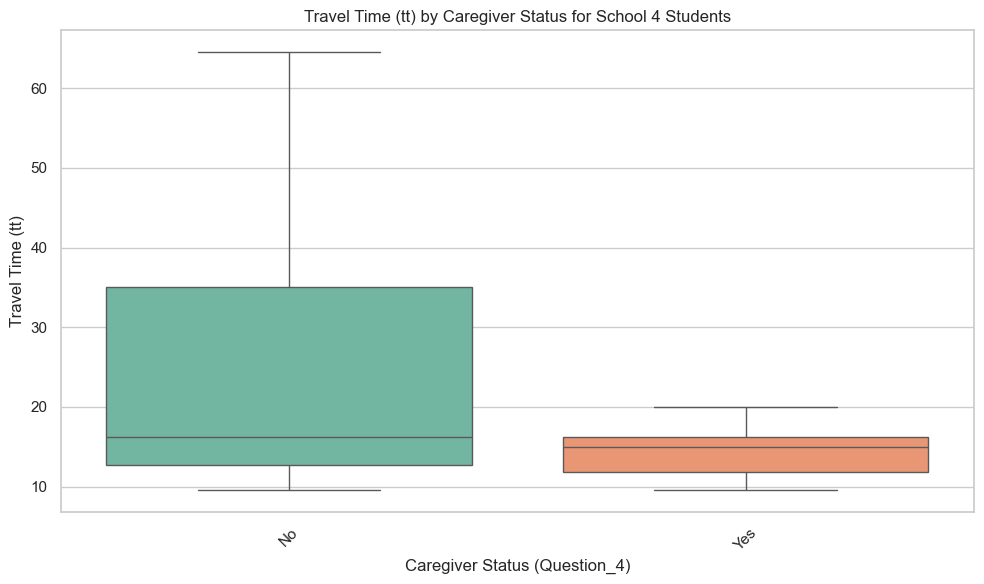

In [92]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=s1, x='Question_4', y='tt', palette = 'Set2')

plt.title('Travel Time (tt) by Caregiver Status for School 1 Students')
plt.xlabel('Caregiver Status (Question_4)')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##############
plt.figure(figsize=(10, 6))
sns.boxplot(data=s2, x='Question_4', y='tt', palette = 'Set2')

plt.title('Travel Time (tt) by Caregiver Status for School 2 Students')
plt.xlabel('Caregiver Status (Question_4)')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############
plt.figure(figsize=(10, 6))
sns.boxplot(data=s3, x='Question_4', y='tt', palette = 'Set2')

plt.title('Travel Time (tt) by Caregiver Status for School 3 Students')
plt.xlabel('Caregiver Status (Question_4)')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##############
plt.figure(figsize=(10, 6))
sns.boxplot(data=s4, x='Question_4', y='tt', palette = 'Set2')

plt.title('Travel Time (tt) by Caregiver Status for School 4 Students')
plt.xlabel('Caregiver Status (Question_4)')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [93]:
from scipy.stats import kruskal

def run_kruskal_test(data, college_name):
    # Drop missing values in relevant columns
    data_cleaned = data.dropna(subset=['Question_4', 'tt'])

    # Group data by caregiver status
    grouped = data_cleaned.groupby('Question_4')['tt'].apply(list)

    # Only run if there are at least 2 caregiver groups
    if len(grouped) >= 2:
        stat, p = kruskal(*grouped)
        print(f"{college_name} - Kruskal-Wallis for Caregiver Status H-statistic: {stat:.4f}, p-value: {p:.4f}")
    else:
        print(f"{college_name} - Not enough caregiver status groups for Kruskal-Wallis test.")

# Run for each college
run_kruskal_test(s1, "School 1")
run_kruskal_test(s2, "School 2")
run_kruskal_test(s3, "School 3")
run_kruskal_test(s4, "School 4")


School 1 - Kruskal-Wallis for Caregiver Status H-statistic: 0.0239, p-value: 0.8772
School 2 - Kruskal-Wallis for Caregiver Status H-statistic: 1.0221, p-value: 0.3120
School 3 - Kruskal-Wallis for Caregiver Status H-statistic: 0.5932, p-value: 0.4412
School 4 - Kruskal-Wallis for Caregiver Status H-statistic: 2.2777, p-value: 0.1312


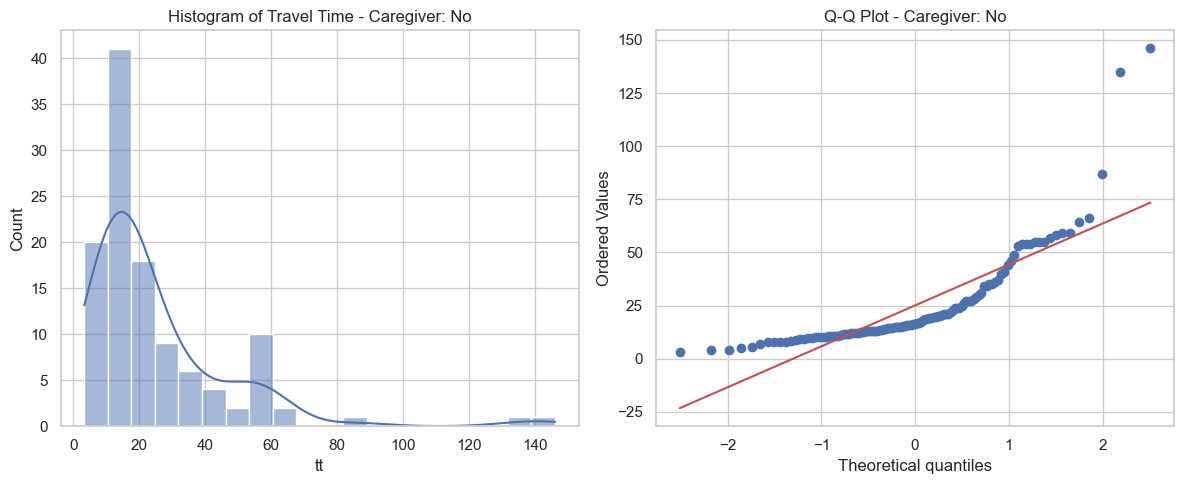

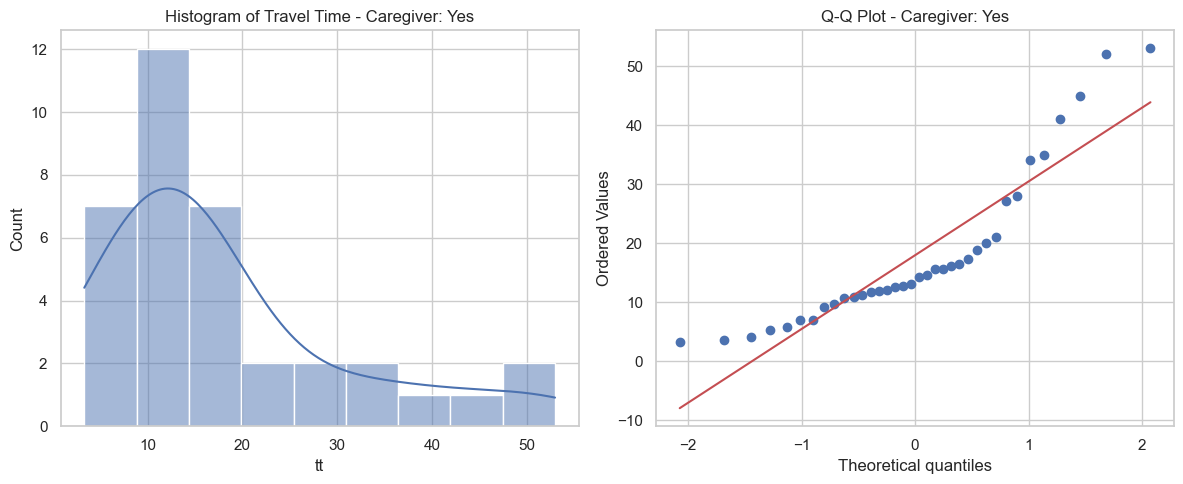

In [63]:
import scipy.stats as stats

from scipy.stats import probplot

# Loop through each caregiver group
for group in survey_subset['Question_4'].dropna().unique():
    subset = survey_subset[survey_subset['Question_4'] == group]['tt'].dropna()
    
    plt.figure(figsize=(12, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(subset, kde=True)
    plt.title(f"Histogram of Travel Time - Caregiver: {group}")

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(subset, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot - Caregiver: {group}")

    plt.tight_layout()
    plt.show()

Data is not normal -  a log transformation on tt will be applied to see if the transform gives mostly normality and then we can proceed with a two-way ANOVA test.

In [64]:
pd.set_option('display.max_columns', None)

survey_clean.columns

Index(['OBJECTID', 'StartDate', 'EndDate', 'Status', 'Progress',
       'Duration__in_seconds_', 'Finished', 'RecordedDate', 'ResponseId',
       'DistributionChannel', 'UserLanguage', 'Agreement', 'Question_1',
       'Question_2', 'Question_3', 'Question_3_7_TEXT', 'Question_4',
       'Question_5', 'Question_6', 'Question_8', 'Question_9',
       'Unique to School', 'Question_10', 'Question_10_7_TEXT', 'Question_11',
       'Question_11_6_TEXT', 'Question_12', 'Question_13', 'Question_14',
       'Question_15', 'Question_16', 'LocationY', 'LocationX', 'School_X',
       'School_Y', 'SortOrder', 'Total_TravelTime', 'Total_Kilometers',
       'Total_Miles', 'Bus/Bike/Walk Time', 'tt'],
      dtype='object')

     OBJECTID        StartDate          EndDate      Status Progress  \
6           8  4/29/2025 11:00  4/29/2025 11:08  IP Address      100   
33         35  4/29/2025 13:39  4/29/2025 13:42  IP Address      100   
47         49  4/30/2025 11:02  4/30/2025 11:05  IP Address      100   
48         50  4/30/2025 11:07  4/30/2025 11:10  IP Address      100   
49         51  4/30/2025 11:30  4/30/2025 11:38  IP Address      100   
50         52  4/30/2025 11:33  4/30/2025 11:45  IP Address      100   
51         53  4/30/2025 11:50  4/30/2025 11:52  IP Address      100   
53         55  4/30/2025 11:50  4/30/2025 11:54  IP Address      100   
54         56  4/30/2025 12:19  4/30/2025 12:23  IP Address      100   
55         57  4/30/2025 11:51  4/30/2025 12:32  IP Address      100   
56         58  4/30/2025 12:38  4/30/2025 12:41  IP Address      100   
58         60  4/30/2025 12:44  4/30/2025 12:48  IP Address      100   
59         61  4/30/2025 12:50  4/30/2025 12:52  IP Address     

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1675894739.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1['tt_log'] = np.log(s1['tt'])
C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1675894739.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s2['tt_log'] = np.log(s2['tt'])
C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1675894739.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

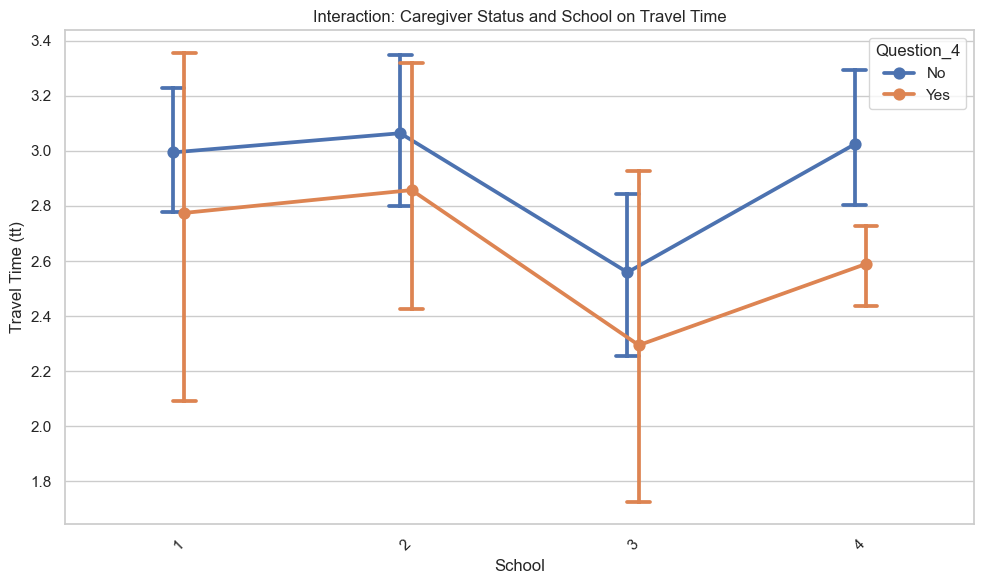

In [94]:
# Drop missing values
survey_clean = survey.dropna(subset=['Question_4', 'tt'])

s1 = survey_clean[survey_clean['Question_6'] == '1']
s2 = survey_clean[survey_clean['Question_6'] == '2']
s3 = survey_clean[survey_clean['Question_6'] == '3']
s4 = survey_clean[survey_clean['Question_6'] == '4']
print(s1)

s1['tt_log'] = np.log(s1['tt'])
s2['tt_log'] = np.log(s2['tt'])
s3['tt_log'] = np.log(s3['tt'])
s4['tt_log'] = np.log(s4['tt'])

# Add a 'school' column to each dataframe
s1['school'] = '1'
s2['school'] = '2'
s3['school'] = '3'
s4['school'] = '4'

# Combine them
combined = pd.concat([s1, s2, s3, s4], ignore_index=True)

# Drop missing values for relevant variables
combined_clean = combined.dropna(subset=['tt_log', 'Question_4', 'school'])

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Define model formula: travel time ~ caregiver + school + interaction
model = ols('tt_log ~ C(Question_4) + C(school) + C(Question_4):C(school)', data=combined_clean).fit()

# Run the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA
print(anova_table)


plt.figure(figsize=(10, 6))
sns.pointplot(data=combined_clean, x='school', y='tt_log', hue='Question_4', dodge=True, markers='o', capsize=.1)
plt.title("Interaction: Caregiver Status and School on Travel Time")
plt.ylabel("Travel Time (tt)")
plt.xlabel("School")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




Normality Checks: School 1
School 1 - No: n=47, W=0.969, p-value=0.2503


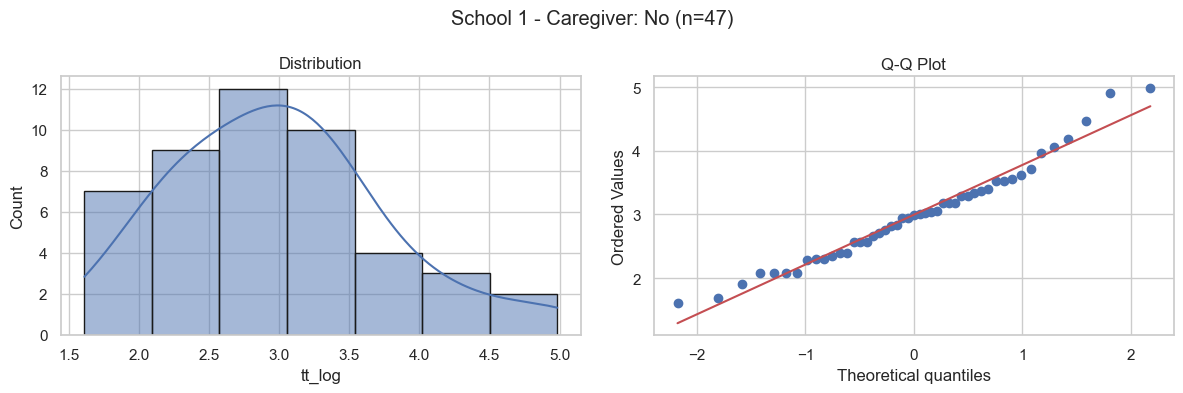

School 1 - Yes: n=7, W=0.919, p-value=0.4594


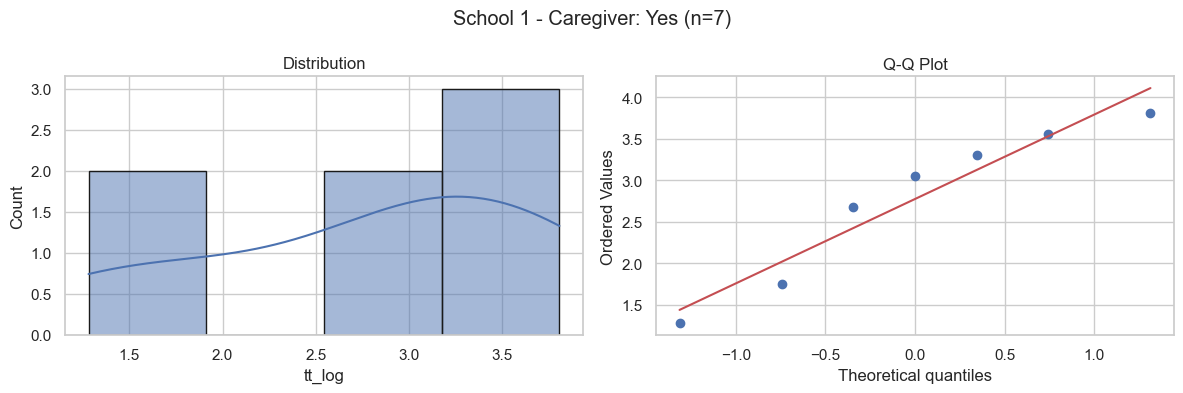


Normality Checks: School 2
School 2 - No: n=24, W=0.865, p-value=0.0042


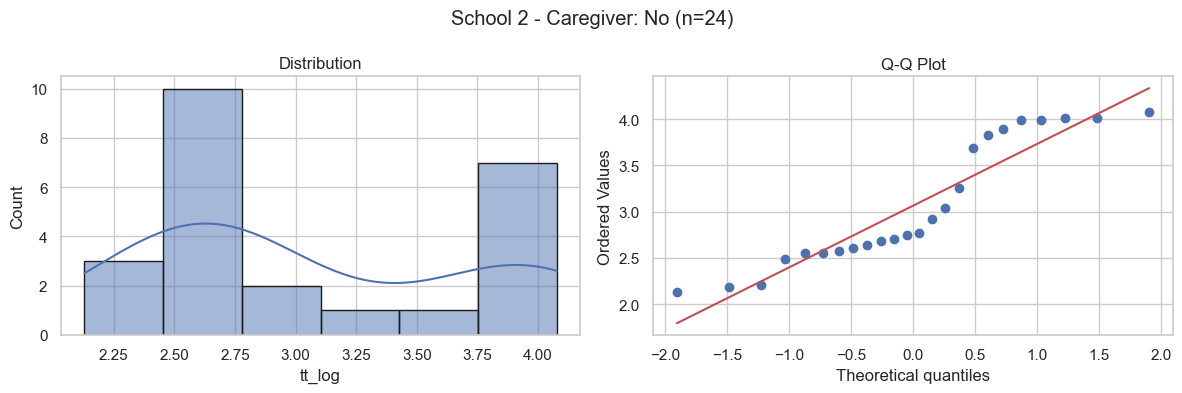

School 2 - Yes: n=9, W=0.904, p-value=0.2788


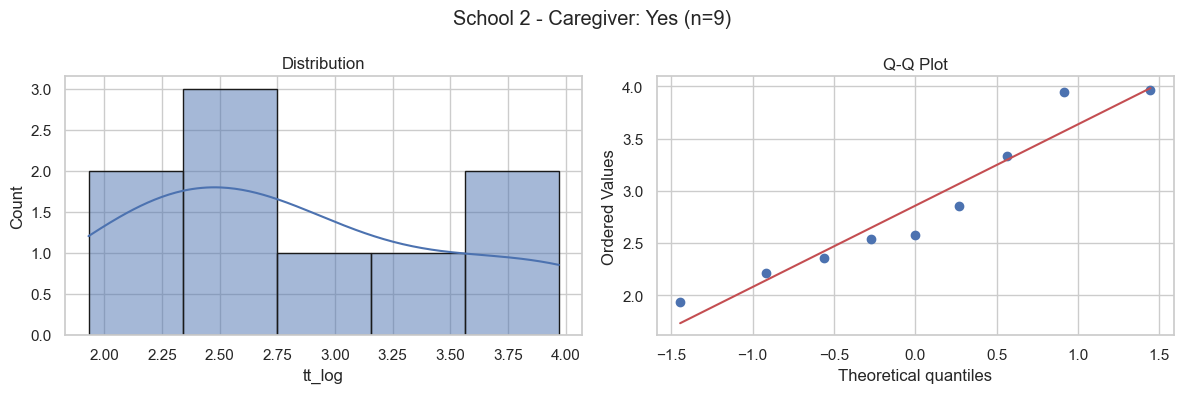


Normality Checks: School 3
School 3 - No: n=19, W=0.936, p-value=0.2219


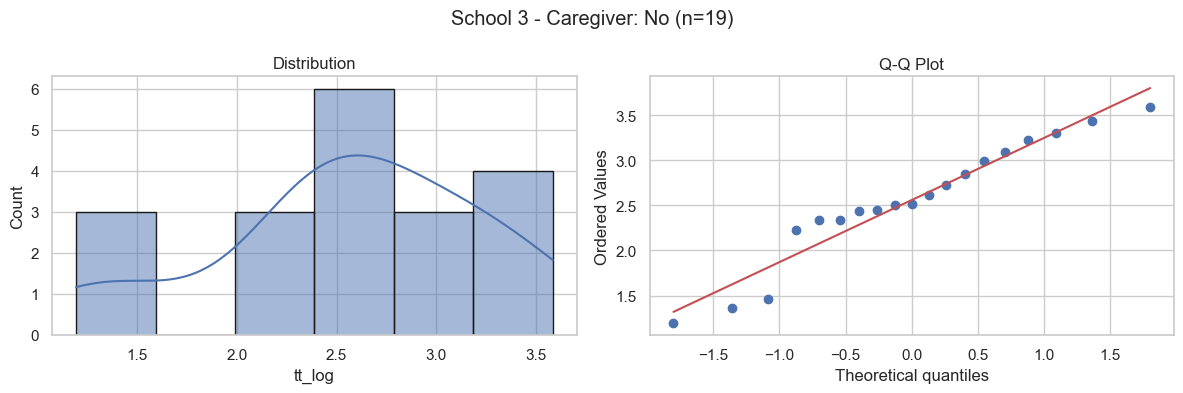

School 3 - Yes: n=8, W=0.919, p-value=0.4190


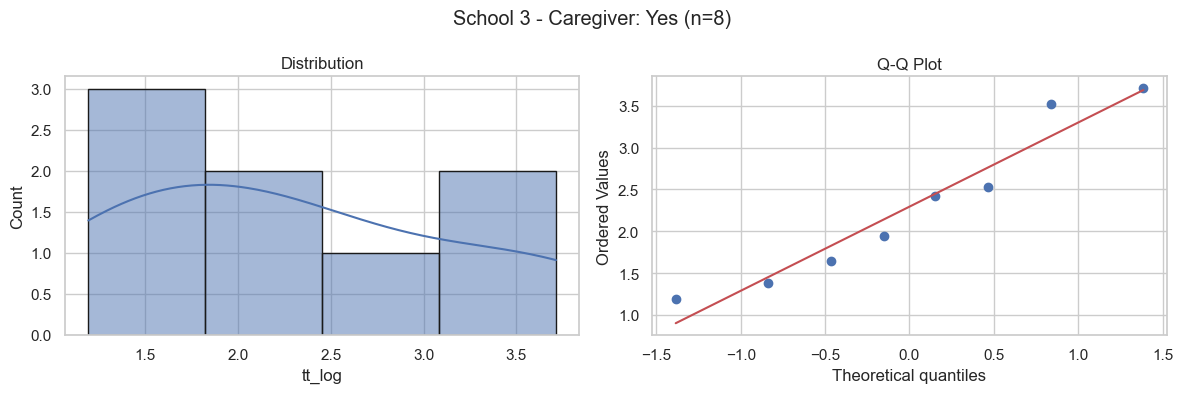


Normality Checks: School 4
School 4 - No: n=25, W=0.849, p-value=0.0017


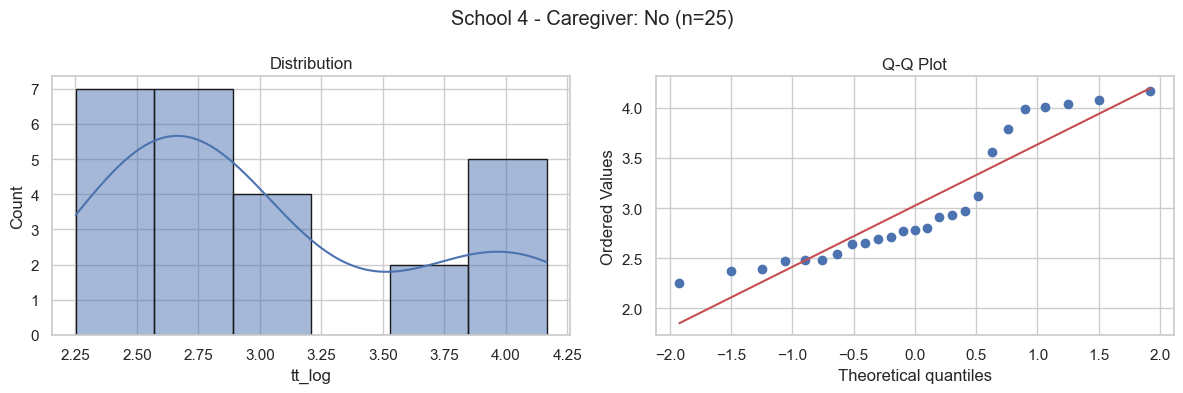

School 4 - Yes: n=13, W=0.948, p-value=0.5706


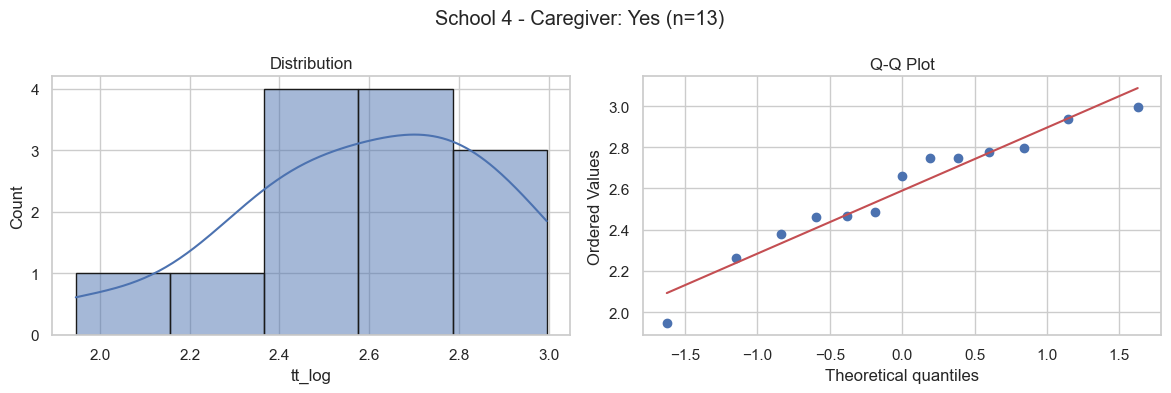

In [66]:
def check_normality(df, school_name):
    results = {}
    grouped = df.groupby('Question_4')['tt_log']
    
    for group_name, group_data in grouped:
        n = len(group_data)
        if n >= 3:
            # Shapiro-Wilk test
            stat, p = stats.shapiro(group_data)
            results[group_name] = {'n': n, 'W': stat, 'p-value': p}
            
            # Print p-value for this group
            print(f"{school_name} - {group_name}: n={n}, W={stat:.3f}, p-value={p:.4f}")
            
            # Generate plots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
            fig.suptitle(f"{school_name} - Caregiver: {group_name} (n={n})")
            
            # Histogram with KDE
            sns.histplot(group_data, kde=True, ax=ax1, edgecolor='k')
            ax1.set_title('Distribution')
            
            # Q-Q plot
            stats.probplot(group_data, dist="norm", plot=ax2)
            ax2.set_title('Q-Q Plot')
            plt.tight_layout()
            plt.show()
        else:
            results[group_name] = f"⚠️ Insufficient data (n={n})"
            print(f"{school_name} - {group_name}: ⚠️ Insufficient data (n={n})")
    
    return results

schools = {
    'School 1': s1,
    'School 2': s2,
    'School 3': s3,
    'School 4': s4
}

results = {}
for name, df in schools.items():
    print(f"\n{'='*40}\nNormality Checks: {name}\n{'='*40}")
    school_results = check_normality(df, name)
    results[name] = school_results


Decent normality and big enough groups for those who don't have normality. So, we can trust the results of the two-way ANOVA above.

GENDER

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1388213278.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=s1, x='Question_2', y='tt', palette = 'Set2')


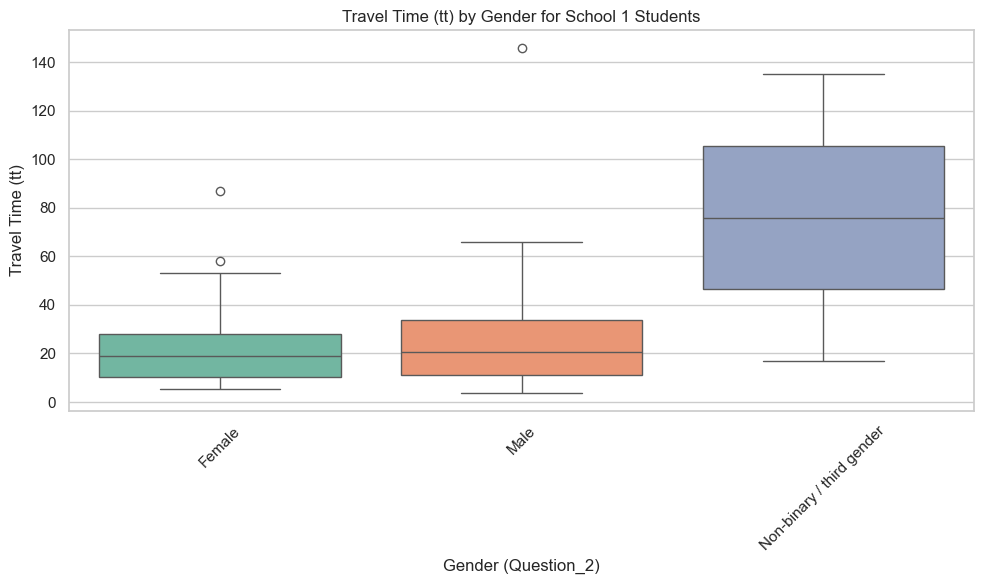

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1388213278.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=s2, x='Question_2', y='tt', palette = 'Set2')


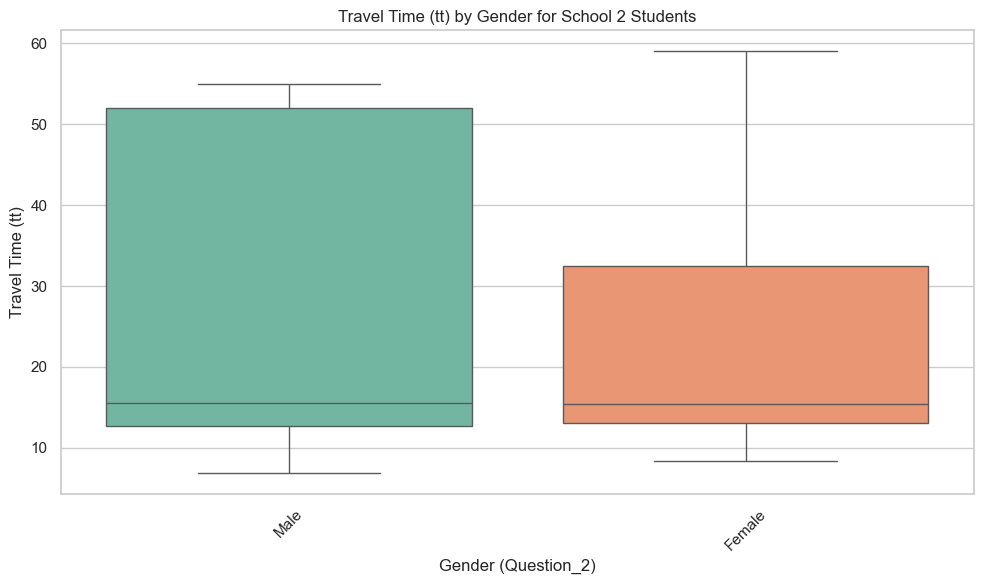

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1388213278.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=s3, x='Question_2', y='tt', palette = 'Set2')


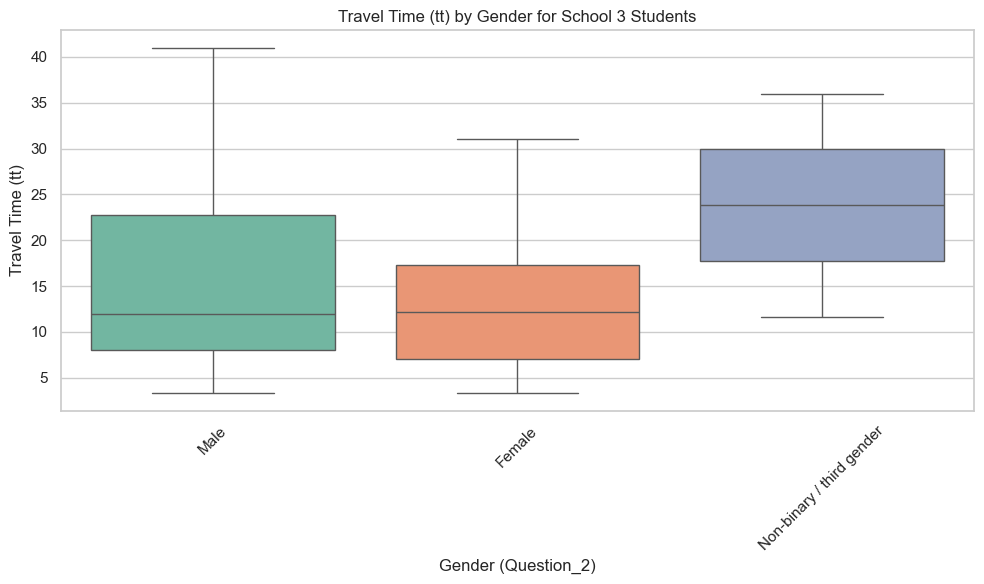

C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1388213278.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=s4, x='Question_2', y='tt', palette = 'Set2')


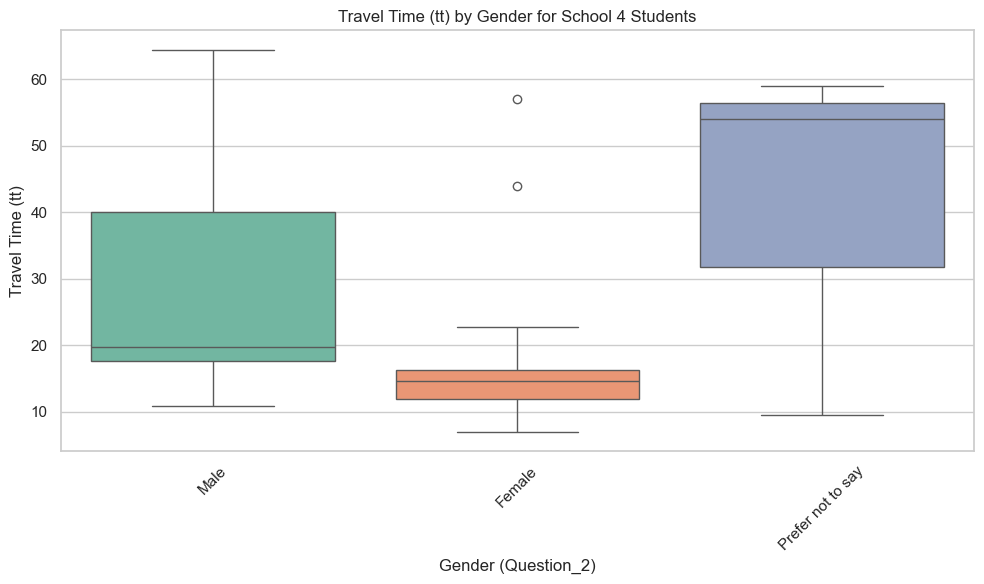

In [96]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=s1, x='Question_2', y='tt', palette = 'Set2')

plt.title('Travel Time (tt) by Gender for School 1 Students')
plt.xlabel('Gender (Question_2)')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##############
plt.figure(figsize=(10, 6))
sns.boxplot(data=s2, x='Question_2', y='tt', palette = 'Set2')

plt.title('Travel Time (tt) by Gender for School 2 Students')
plt.xlabel('Gender (Question_2)')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############
plt.figure(figsize=(10, 6))
sns.boxplot(data=s3, x='Question_2', y='tt', palette = 'Set2')

plt.title('Travel Time (tt) by Gender for School 3 Students')
plt.xlabel('Gender (Question_2)')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##############
plt.figure(figsize=(10, 6))
sns.boxplot(data=s4, x='Question_2', y='tt', palette = 'Set2')

plt.title('Travel Time (tt) by Gender for School 4 Students')
plt.xlabel('Gender (Question_2)')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [97]:
from scipy.stats import kruskal

def run_kruskal_test_gender(data, college_name):
    # Drop missing values in relevant columns
    data_cleaned = data.dropna(subset=['Question_2', 'tt'])

    # Group travel time by gender
    grouped = data_cleaned.groupby('Question_2')['tt'].apply(list)

    # Run test only if 2 or more gender groups are present
    if len(grouped) >= 2:
        stat, p = kruskal(*grouped)
        print(f"{college_name} - Kruskal-Wallis H-statistic: {stat:.4f}, p-value: {p:.4f}")
    else:
        print(f"{college_name} - Not enough gender groups for Kruskal-Wallis test.")

# Apply to each dataset
run_kruskal_test_gender(s1, "School 1")
run_kruskal_test_gender(s2, "School 2")
run_kruskal_test_gender(s3, "School 3")
run_kruskal_test_gender(s4, "School 4")


School 1 - Kruskal-Wallis H-statistic: 1.0342, p-value: 0.5963
School 2 - Kruskal-Wallis H-statistic: 0.0029, p-value: 0.9569
School 3 - Kruskal-Wallis H-statistic: 1.0723, p-value: 0.5850
School 4 - Kruskal-Wallis H-statistic: 5.2356, p-value: 0.0730


C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\3111180910.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major_group', y='tt', data=survey_clean, palette='Set3')


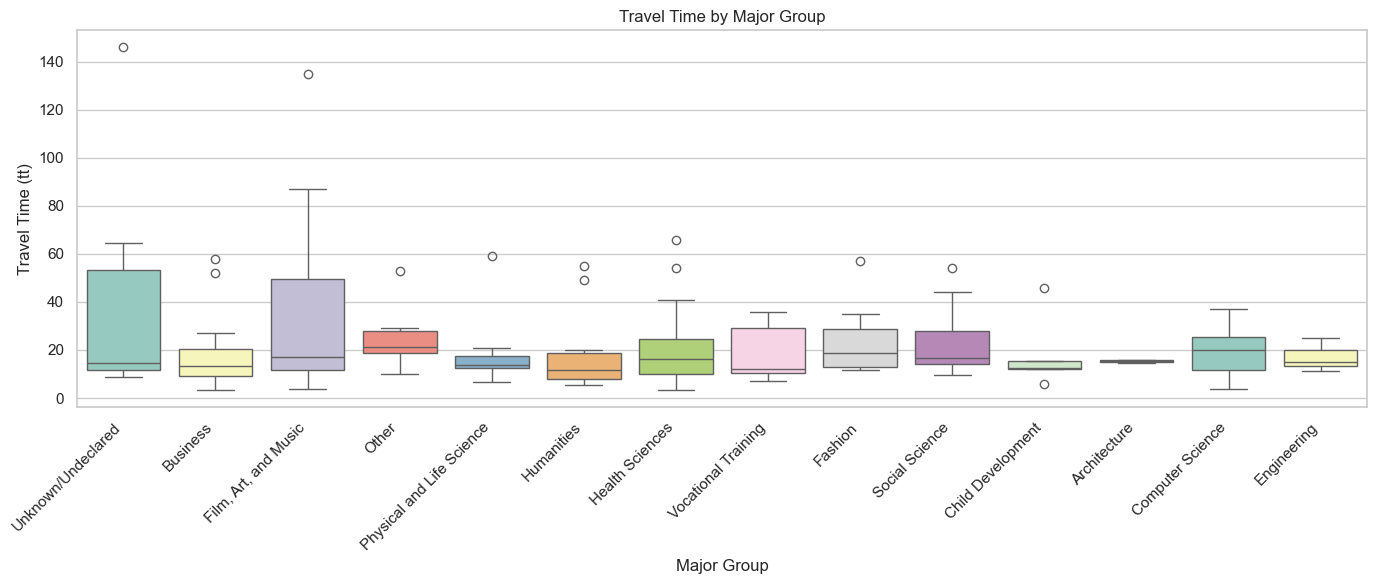

In [69]:
# group_mapping = [
#     (['Fashion', 'Apparel Design', 'Merchandising'], 'Fashion'),
#     (['Business', 'Business Economics', 'Business Administration', 'Real Estate', 'Buisness'], 'Business'),
#     (['Film', 'Multimedia', 'Digital Imaging', 'Art', 'Graphic Design', 'Music', 'Music Production', 'Music, Art'], 'Film, Art, and Music'),
#     (['Engineering', 'Mechanical Engineering', 'Electrical Engineering'], 'Engineering'),
#     (['Unknown', 'Undeclared', 'Blank', 'General Studies', 'Undecided'], 'Unknown/Undeclared'),
#     (['Psychology', 'Sociology', 'Social Work', 'Administration of Justice', 'Political Science', 'Criminal justice', 'Legal Studies', 'Urban Studies'], 'Social Science'),
#     (['EMT', 'Fire Science', 'Culinary Arts', 'Carpentry'], 'Vocational Training'),
#     (['Computer Science', 'Cybersecurity', 'Data Science', 'Computer science'], 'Computer Science'),
#     (['Physics', 'Astronomy', 'Biology', 'Biotechnology', 'Natural Sciences', 'Neuroscience', 'Chemistry', 'Marine Biology', 'Psycology, Neuroscience', 'Math', 'Mathmatics'], 'Physical and Life Science'),
#     (['Nursing', 'Physician Assistant', 'Radiology', 'Medicine', 'Kinesiology', 'Public Health', 'Nurse', 'Health Science', 'Accounting, Healthcare', 'Nutrition'], 'Health Sciences'),
#     (['Japanese', 'Spanish', 'Communications', 'Communication', 'Humanities', 'English', 'History', 'Philosophy', 'Liberal Arts'], 'Humanities'),
#     (['Child Development'], 'Child Development'),
#     (['Architecture', 'Landscape Architecture'], 'Architecture'),
# ]

# Step 1: Build the mapping dictionary
major_dict = {}
for keywords, group_name in [
    (['Fashion', 'Apparel Design', 'Merchandising'], 'Fashion'),
    (['Business', 'Business Economics', 'Business Administration', 'Real Estate', 'Buisness'], 'Business'),
    (['Film', 'Multimedia', 'Digital Imaging', 'Art', 'Graphic Design', 'Music', 'Music Production ', 'Music, Art', 'Art History'], 'Film, Art, and Music'),
    (['Engineering', 'Mechanical Engineering', 'Electrical Engineering'], 'Engineering'),
    (['Unknown', 'Undeclared', 'Blank', 'General Studies', 'Undecided'], 'Unknown/Undeclared'),
    (['Psychology', 'Sociology', 'Social Work', 'Administration of Justice', 'Political Science', 'Criminal justice', 'Legal Studies', 'Urban Studies'], 'Social Science'),
    (['EMT', 'Fire Science', 'Culinary Arts', 'Carpentry'], 'Vocational Training'),
    (['Computer Science', 'Cybersecurity', 'Data Science', 'Computer science'], 'Computer Science'),
    (['Physics', 'Astronomy', 'Biology', 'Biotechnology', 'Natural Sciences', 'Neuroscience', 'Chemistry', 'Marine Biology', 'Psycology, Neuroscience', 'Math', 'Mathmatics'], 'Physical and Life Science'),
    (['Nursing', 'Physician Assistant', 'Radiology', 'Medicine', 'Kinesiology', 'Public Health', 'Nurse', 'Health Science', 'Accounting, Healthcare', 'Nutrition'], 'Health Sciences'),
    (['Japanese', 'Spanish', 'Communications', 'Communication', 'Humanities', 'English', 'History', 'Philosophy', 'Liberal Arts'], 'Humanities'),
    (['Child Development'], 'Child Development'),
    (['Architecture', 'Landscape Architecture'], 'Architecture'),
]:
    for keyword in keywords:
        major_dict[keyword.strip().lower()] = group_name

# Step 2: Map majors to groups (case-insensitive match)
def map_major(response):
    key = str(response).strip().lower()
    return major_dict.get(key, 'Other')

survey['major_group'] = survey['Question_9'].apply(map_major)

# Step 3: Drop rows with missing tt or unmapped major group
survey_clean = survey.dropna(subset=['tt', 'major_group'])

# Step 4: Plot
plt.figure(figsize=(14, 6))
sns.boxplot(x='major_group', y='tt', data=survey_clean, palette='Set3')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Major Group')
plt.ylabel('Travel Time (tt)')
plt.title('Travel Time by Major Group')
plt.tight_layout()
plt.show()



In [70]:
# Drop missing values in relevant columns
survey_clean = survey.dropna(subset=['tt', 'major_group'])

# Group travel times by each major group
grouped_tt = [
    group['tt'].values
    for name, group in survey_clean.groupby('major_group')
]

# Run Kruskal-Wallis H-test
stat, p = kruskal(*grouped_tt)

# Display results
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.4f}")

if p < 0.05:
    print("→ Statistically significant difference in travel time across major groups (p < 0.05)")
elif p < 0.10:
    print("→ Moderate evidence of a difference in travel time (p < 0.10)")
else:
    print("→ No significant difference in travel time across major groups (p ≥ 0.10)")



Kruskal-Wallis H-statistic = 9.336, p-value = 0.7471
→ No significant difference in travel time across major groups (p ≥ 0.10)


In [71]:
# Now check across schools
kruskal_results = []

# For each school, group travel times by 'major_group' and perform Kruskal-Wallis test
for school, group in survey_clean.groupby('Question_6'):
    grouped_tt = [grp['tt'].values for name, grp in group.groupby('major_group') if len(grp) > 0]
    if len(grouped_tt) > 1:  # Need at least 2 groups to compare
        stat, p = kruskal(*grouped_tt)
        kruskal_results.append({'school': school, 'stat': stat, 'p_value': p})
    else:
        kruskal_results.append({'school': school, 'stat': None, 'p_value': None})

# Display results
for result in kruskal_results:
    school = result['school']
    stat = result['stat']
    p = result['p_value']
    if stat is not None:
        print(f"{school}: Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.4f}")
        if p < 0.05:
            print("→ Statistically significant difference in travel time across major groups (p < 0.05)")
        elif p < 0.10:
            print("→ Moderate evidence of a difference in travel time (p < 0.10)")
        else:
            print("→ No significant difference in travel time across major groups (p ≥ 0.10)")
    else:
        print(f"{school}: Not enough groups to perform Kruskal-Wallis test.")

1: Kruskal-Wallis H-statistic = 16.482, p-value = 0.0866
→ Moderate evidence of a difference in travel time (p < 0.10)
2: Kruskal-Wallis H-statistic = 9.883, p-value = 0.3601
→ No significant difference in travel time across major groups (p ≥ 0.10)
3: Kruskal-Wallis H-statistic = 9.415, p-value = 0.5836
→ No significant difference in travel time across major groups (p ≥ 0.10)
4: Kruskal-Wallis H-statistic = 3.211, p-value = 0.9760
→ No significant difference in travel time across major groups (p ≥ 0.10)


C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\4091376819.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major_group', y='tt', data=school_data, ax=ax, palette='pastel')
C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\4091376819.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major_group', y='tt', data=school_data, ax=ax, palette='pastel')
C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\4091376819.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major_group', y='tt', data=school_data, ax=ax, palette='pastel')
C

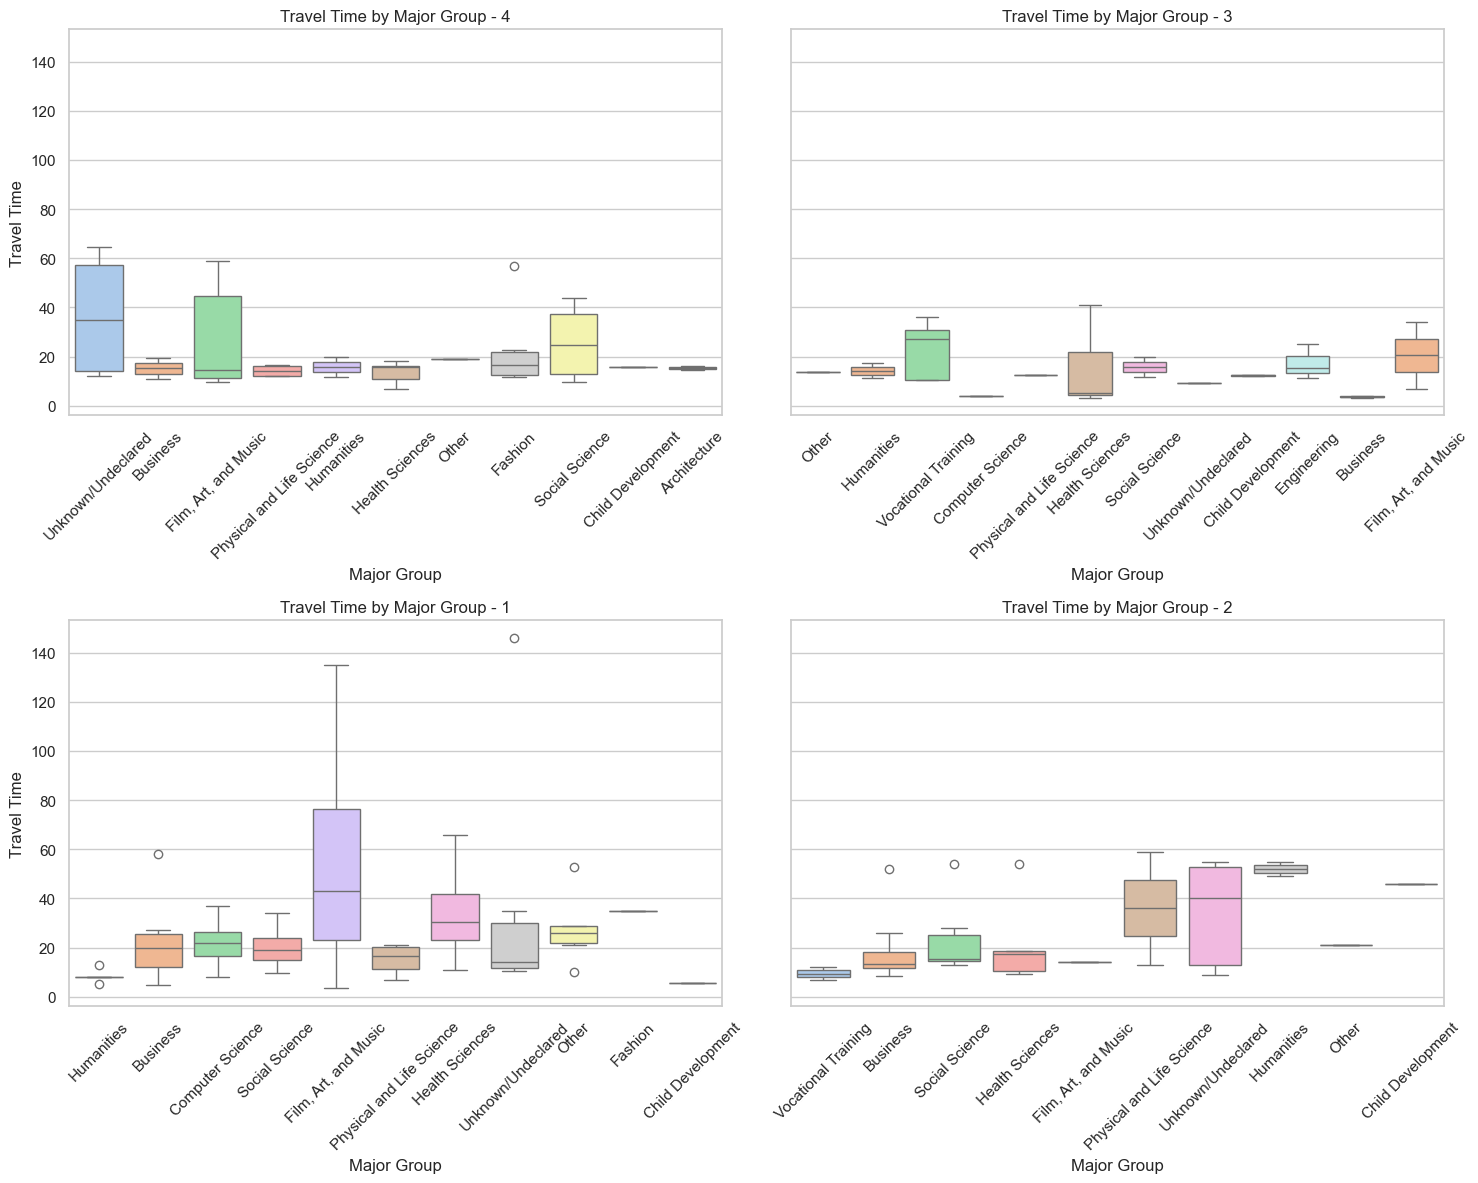

In [72]:
# Clean the data by dropping missing values in relevant columns
survey_clean = survey.dropna(subset=['tt', 'Question_6', 'major_group'])

# Get unique schools
schools = survey_clean['Question_6'].unique()

# Prepare the figure with 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=True)
axes = axes.flatten()

# Plot boxplots for each school
for i, school in enumerate(schools):
    ax = axes[i]
    school_data = survey_clean[survey_clean['Question_6'] == school]
    sns.boxplot(x='major_group', y='tt', data=school_data, ax=ax, palette='pastel')
    ax.set_title(f'Travel Time by Major Group - {school}')
    ax.set_xlabel('Major Group')
    ax.set_ylabel('Travel Time')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [73]:
from scipy.stats import mannwhitneyu
# Drop missing values
survey_clean = survey.dropna(subset=['tt', 'major_group'])

# Get unique major groups
major_groups = survey_clean['major_group'].unique()

# Store results
results = []

for group in major_groups:
    # Travel times for this group
    group_tt = survey_clean[survey_clean['major_group'] == group]['tt']
    
    # Travel times for all other groups
    others_tt = survey_clean[survey_clean['major_group'] != group]['tt']
    
    # Perform Mann-Whitney U test
    stat, p = mannwhitneyu(group_tt, others_tt, alternative='two-sided')
    
    # Append result
    results.append({
        'Major Group': group,
        'U Statistic': stat,
        'p-value': p,
        'n_group': len(group_tt),
        'n_others': len(others_tt),
        'Median_tt_group': group_tt.median(),
        'Median_tt_others': others_tt.median()
    })

# Convert to DataFrame
mw_results = pd.DataFrame(results)

# Sort by p-value
mw_results = mw_results.sort_values(by='p-value')

# Show results
print(mw_results[['Major Group', 'U Statistic', 'p-value', 'Median_tt_group', 'Median_tt_others', 'n_group', 'n_others']])

                  Major Group  U Statistic   p-value  Median_tt_group  \
5                  Humanities        588.0  0.183563            11.80   
3                       Other        812.5  0.188351            21.10   
1                    Business        978.5  0.195486            13.30   
2        Film, Art, and Music       1202.5  0.280987            17.00   
0          Unknown/Undeclared       1249.5  0.333721            14.75   
9              Social Science       1552.0  0.347317            16.80   
6             Health Sciences       1137.5  0.484416            16.10   
10          Child Development        301.0  0.495351            12.50   
8                     Fashion        584.5  0.501258            18.80   
4   Physical and Life Science        760.0  0.586971            13.60   
7         Vocational Training        445.5  0.588751            12.00   
13                Engineering        215.0  0.915601            15.20   
11               Architecture        144.5  0.93556

In [74]:
film_art_music = survey[survey['major_group'] == 'Film, Art, and Music']

# Get number of students in this group
print(f"\nNumber of students in 'Film, Art, and Music': {len(film_art_music)}")

# Check median travel time
print(f"Median travel time: {film_art_music['tt'].median()}")


print(len(survey['tt']))


Number of students in 'Film, Art, and Music': 16
Median travel time: 17.0
166


In [75]:
film_art_music[['Question_6','Question_9', 'tt']]


,Question_6,Question_9,tt
2,4,Film,16.4
22,4,Art,54.0
30,4,Art,59.0
38,4,Graphic Design,10.7
39,4,Art History,NaN
40,4,Art,9.5
42,4,Art History,12.7
53,1,Film,87.0
56,1,Film,17.0
81,2,Music Production,14.0


Transportation Barriers

Mode share and types of barriers

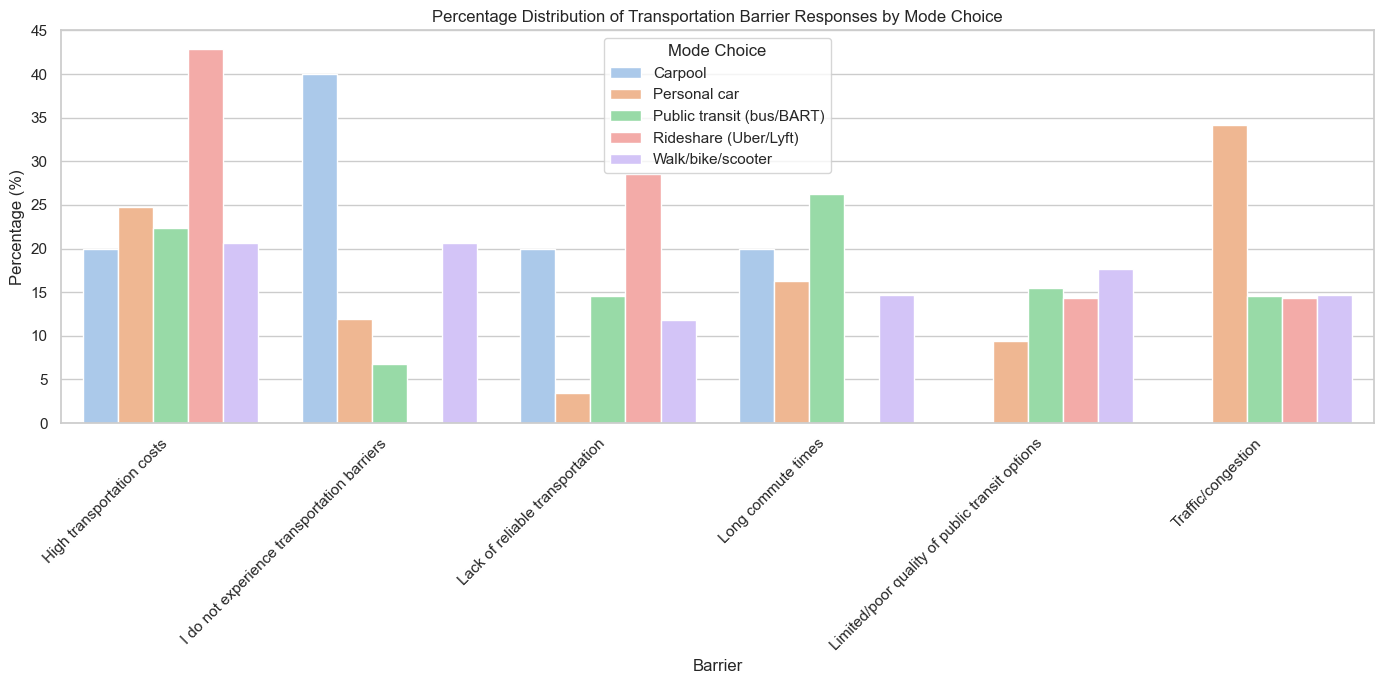

In [76]:
# Ensure no missing values in relevant columns
survey_clean = survey_clean.dropna(subset=['Question_12', 'Question_13']).reset_index(drop=True)

# Split and explode barrier responses
survey_clean['Response'] = survey_clean['Question_13'].str.split(',')
exploded = survey_clean.explode('Response')
exploded['Response'] = exploded['Response'].str.strip()
exploded['Response'] = exploded['Response'].replace('Other: (please describe)', 'Other')

# Count and calculate percentages
response_counts = exploded.groupby(['Question_12', 'Response']).size().reset_index(name='Count')
mode_totals = response_counts.groupby('Question_12')['Count'].sum().reset_index(name='Total')
response_counts = response_counts.merge(mode_totals, on='Question_12')
response_counts['Percentage'] = (response_counts['Count'] / response_counts['Total']) * 100

# Plot grouped bar chart
plt.figure(figsize=(14, 7))
sns.barplot(data=response_counts, x='Response', y='Percentage', hue='Question_12', palette='pastel')
plt.title('Percentage Distribution of Transportation Barrier Responses by Mode Choice')
plt.xlabel('Barrier')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Mode Choice')
plt.show()


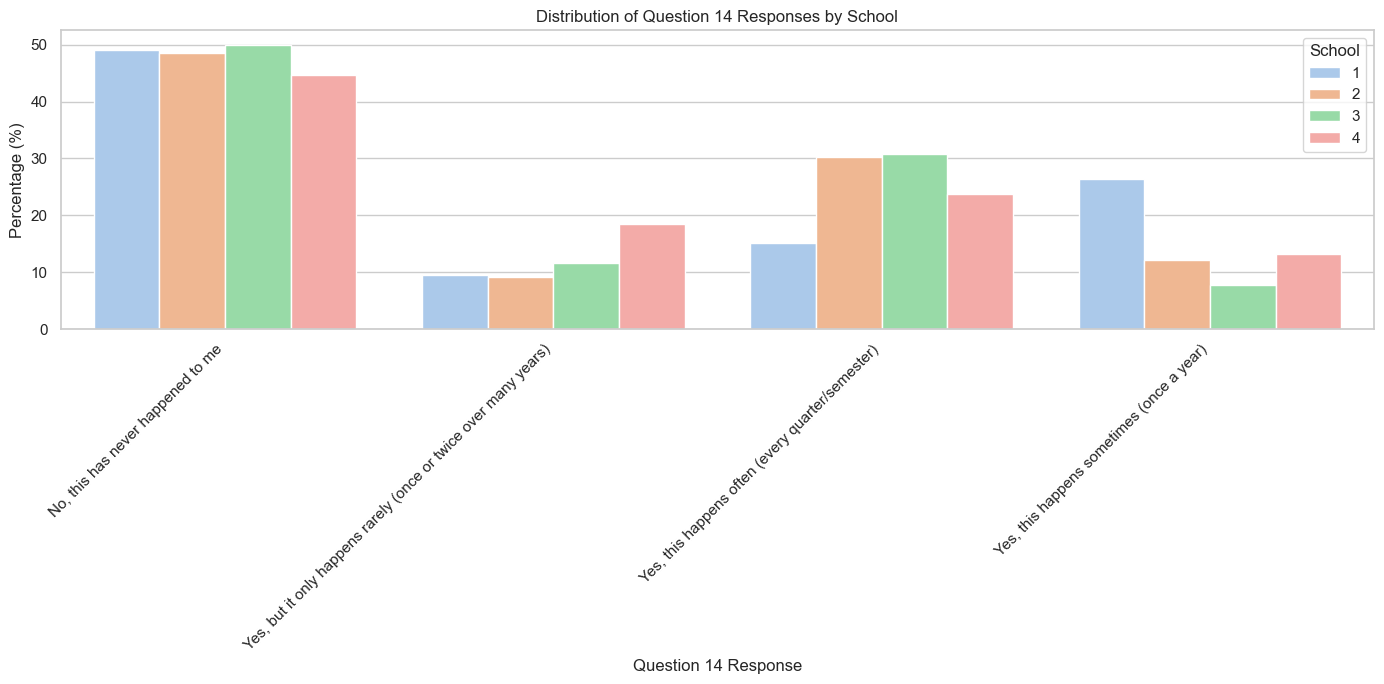

Chi-square statistic: 9.77
p-value: 0.3695
→ No significant difference in the distribution of Question_14 responses across schools (p ≥ 0.05)


In [77]:

# Drop missing values in relevant columns
df = survey_clean.dropna(subset=['Question_6', 'Question_14'])

# Count responses per school and response
counts = df.groupby(['Question_6', 'Question_14']).size().reset_index(name='Count')

# Calculate total responses per school for percentage
totals = counts.groupby('Question_6')['Count'].sum().reset_index(name='Total')
counts = counts.merge(totals, on='Question_6')
counts['Percentage'] = (counts['Count'] / counts['Total']) * 100

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(
    data=counts,
    x='Question_14',
    y='Percentage',
    hue='Question_6',
    palette='pastel'
)
plt.title('Distribution of Question 14 Responses by School')
plt.xlabel('Question 14 Response')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='School')
plt.tight_layout()
plt.show()


# Create a contingency table: rows = schools, columns = Question_14 responses
contingency = pd.crosstab(survey_clean['Question_6'], survey_clean['Question_14'])

# Run the Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency)

print(f'Chi-square statistic: {chi2:.2f}')
print(f'p-value: {p:.4f}')

if p < 0.05:
    print("→ Statistically significant difference in the distribution of Question_14 responses across schools (p < 0.05)")
else:
    print("→ No significant difference in the distribution of Question_14 responses across schools (p ≥ 0.05)")



C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1007618807.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Transportation Mode', y='Percentage', data=mode_counts, palette='pastel')


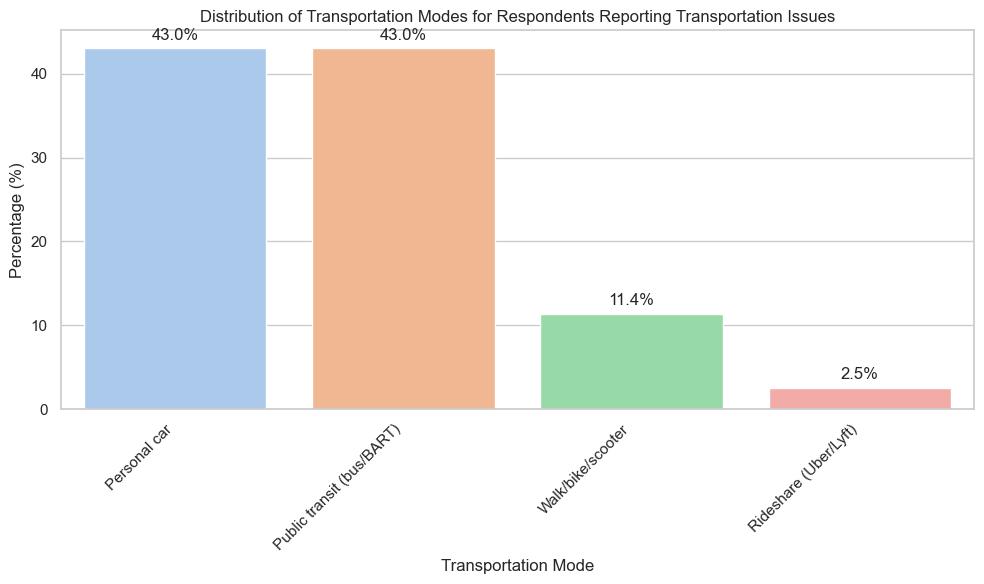

In [78]:
# Filter respondents who did NOT choose 'No, this has never happened to me' in Question_14
filtered = survey_clean[survey_clean['Question_14'] != 'No, this has never happened to me']

# Count transportation modes (Question_12) for these respondents, as percentages
mode_counts = filtered['Question_12'].value_counts(normalize=True).reset_index()
mode_counts.columns = ['Transportation Mode', 'Percentage']
mode_counts['Percentage'] *= 100

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Transportation Mode', y='Percentage', data=mode_counts, palette='pastel')
plt.title('Distribution of Transportation Modes for Respondents Reporting Transportation Issues')
plt.xlabel('Transportation Mode')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')

# Add percentage labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 1, f'{height:.1f}%', ha='center')

plt.tight_layout()
plt.show()


C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\3559772894.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Transportation Mode', y='Percentage', data=mode_counts, palette='pastel')


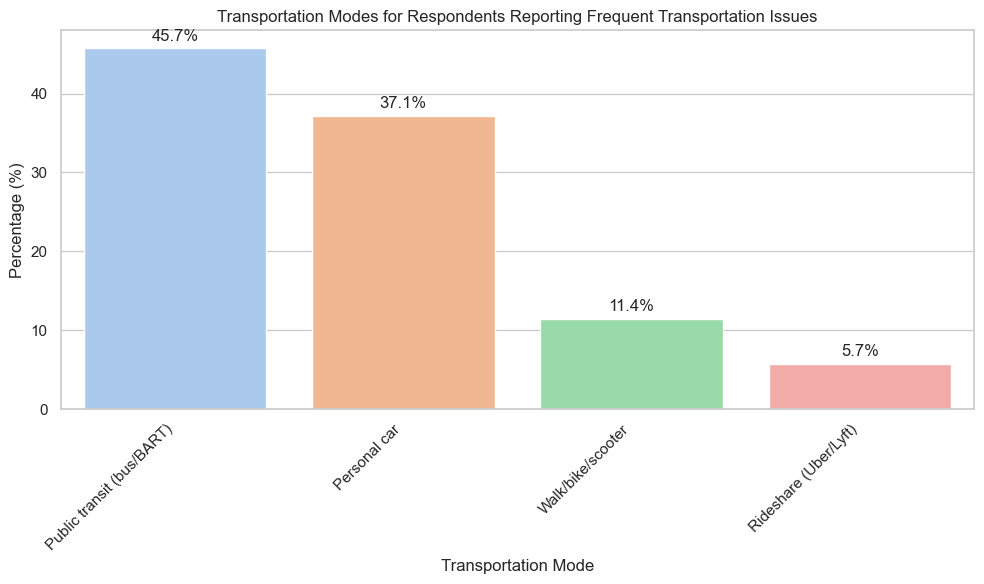

2          Rideshare (Uber/Lyft)
3                   Personal car
15                  Personal car
21     Public transit (bus/BART)
24             Walk/bike/scooter
28     Public transit (bus/BART)
32                  Personal car
36                  Personal car
38                  Personal car
40     Public transit (bus/BART)
51     Public transit (bus/BART)
62     Public transit (bus/BART)
63                  Personal car
64                  Personal car
74                  Personal car
78     Public transit (bus/BART)
79     Public transit (bus/BART)
84         Rideshare (Uber/Lyft)
99     Public transit (bus/BART)
101            Walk/bike/scooter
103                 Personal car
105                 Personal car
115                 Personal car
117    Public transit (bus/BART)
122                 Personal car
124    Public transit (bus/BART)
133            Walk/bike/scooter
134            Walk/bike/scooter
136    Public transit (bus/BART)
140    Public transit (bus/BART)
143    Pub

In [79]:
# Filter for respondents with the specified answer in Question_14
often = survey_clean[survey_clean['Question_14'] == "Yes, this happens often (every quarter/semester)"]

# Count and calculate percentages for each transportation mode
mode_counts = often['Question_12'].value_counts(normalize=True).reset_index()
mode_counts.columns = ['Transportation Mode', 'Percentage']
mode_counts['Percentage'] *= 100

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Transportation Mode', y='Percentage', data=mode_counts, palette='pastel')
plt.title('Transportation Modes for Respondents Reporting Frequent Transportation Issues')
plt.xlabel('Transportation Mode')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')

# Add percentage labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 1, f'{height:.1f}%', ha='center')

plt.tight_layout()
plt.show()
often['Question_12']

In [80]:

import pandas as pd
from scipy.stats import chi2_contingency

# Define the exact string indicating public transit users
public_transit_string = 'Public transit (bus/BART)'

# Create indicator columns for public transit usage
survey_clean['public_transit'] = survey_clean['Question_12'] == public_transit_string
often['public_transit'] = often['Question_12'] == public_transit_string

# Count total students by transit type in survey_clean
total_public_transit = survey_clean['public_transit'].sum()
total_non_public_transit = (~survey_clean['public_transit']).sum()

# Count students who often report issues by transit type in often
often_public_transit = often['public_transit'].sum()
often_non_public_transit = (~often['public_transit']).sum()

# Create contingency table
a = often_public_transit                          # Public transit AND often issues
b = total_public_transit - often_public_transit  # Public transit AND NOT often issues
c = often_non_public_transit                      # Not public transit AND often issues
d = total_non_public_transit - often_non_public_transit  # Not public transit AND NOT often issues

contingency_table = pd.DataFrame(
    [[a, b],
     [c, d]],
    index=['Public Transit', 'Not Public Transit'],
    columns=['Often Issues', 'Not Often Issues']
)

print("Contingency Table:")
print(contingency_table)

# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square statistic: {chi2:.3f}")
print(f"P-value: {p:.4f}")

if p < 0.05:
    print("There is a statistically significant association between public transit use and reporting often transportation issues.")
else:
    print("No statistically significant association found.")

# Proportions
prop_public_transit_often = a / total_public_transit if total_public_transit > 0 else 0
prop_non_public_transit_often = c / total_non_public_transit if total_non_public_transit > 0 else 0

print(f"\nProportion of public transit users who report often issues: {prop_public_transit_often:.2%}")
print(f"Proportion of non-public transit users who report often issues: {prop_non_public_transit_often:.2%}")



Contingency Table:
                    Often Issues  Not Often Issues
Public Transit                16                39
Not Public Transit            19                77

Chi-square statistic: 1.216
P-value: 0.2701
No statistically significant association found.

Proportion of public transit users who report often issues: 29.09%
Proportion of non-public transit users who report often issues: 19.79%


C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\2564338863.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  often['public_transit'] = often['Question_12'] == public_transit_string


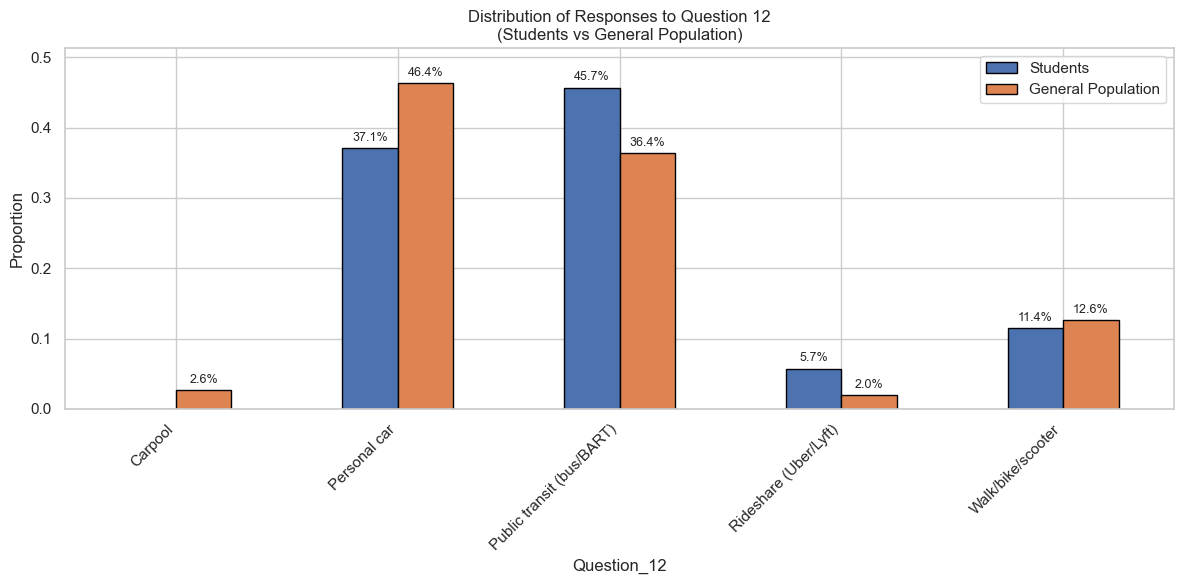

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate relative frequencies
student_q12 = often['Question_12'].value_counts(normalize=True)
general_q12 = survey_clean['Question_12'].value_counts(normalize=True)

# Combine into one DataFrame
q12_comparison = pd.DataFrame({
    'Students': student_q12,
    'General Population': general_q12
}).fillna(0)

# Sort index for consistent order
q12_comparison = q12_comparison.sort_index()

# Plot
ax = q12_comparison.plot(kind='bar', figsize=(12, 6), edgecolor='black')
plt.ylabel('Proportion')
plt.title('Distribution of Responses to Question 12\n(Students vs General Population)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, q12_comparison.max().max() + 0.05)  # leave space for labels

# Add percent labels on top of each bar
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height*100:.1f}%',  # format as percent
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\1284175718.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Barrier', y='Percentage', data=barrier_counts, palette='viridis')


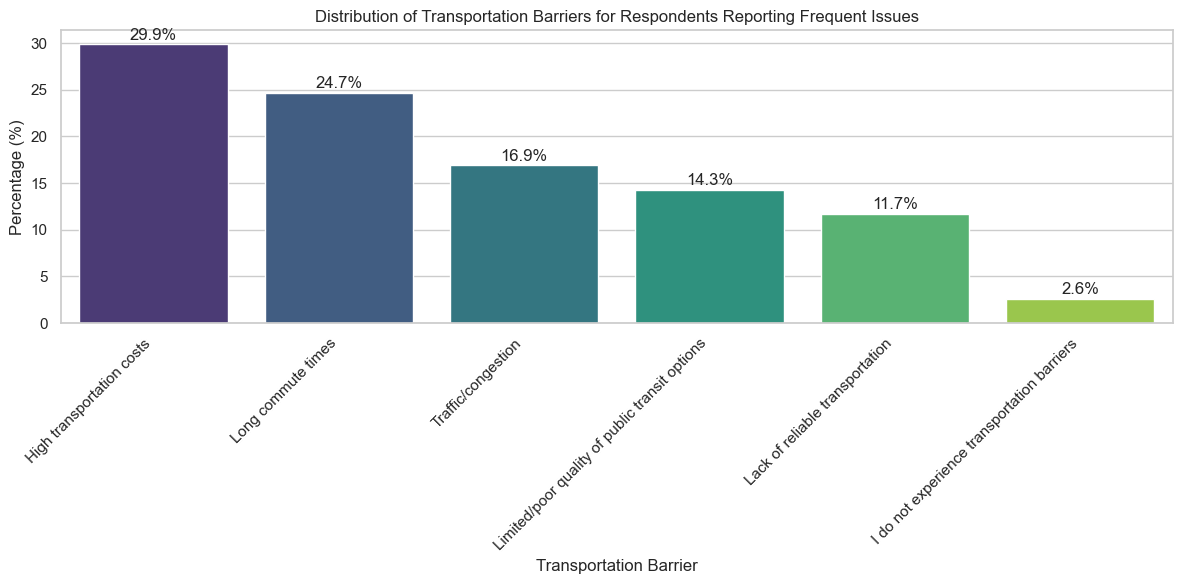

In [82]:
# Filter for respondents with the specified answer in Question_14 and non-missing Question_13
often = survey_clean[
    (survey_clean['Question_14'] == "Yes, this happens often (every quarter/semester)") &
    (survey_clean['Question_13'].notna())
]

# Split and explode the barriers (in case of multiple selections)
often = often.assign(Barrier=often['Question_13'].str.split(','))
often = often.explode('Barrier')
often['Barrier'] = often['Barrier'].str.strip()
often['Barrier'] = often['Barrier'].replace('Other: (please describe)', 'Other')

# Count and calculate percentages for each barrier
barrier_counts = often['Barrier'].value_counts(normalize=True).reset_index()
barrier_counts.columns = ['Barrier', 'Percentage']
barrier_counts['Percentage'] *= 100

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Barrier', y='Percentage', data=barrier_counts, palette='viridis')
plt.title('Distribution of Transportation Barriers for Respondents Reporting Frequent Issues')
plt.xlabel('Transportation Barrier')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')

# Add percentage labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.5, f'{height:.1f}%', ha='center')

plt.tight_layout()
plt.show()


C:\Users\jcoll\AppData\Local\Temp\ipykernel_32832\2588014792.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Barrier', y='Percentage', data=barrier_counts, palette='viridis')


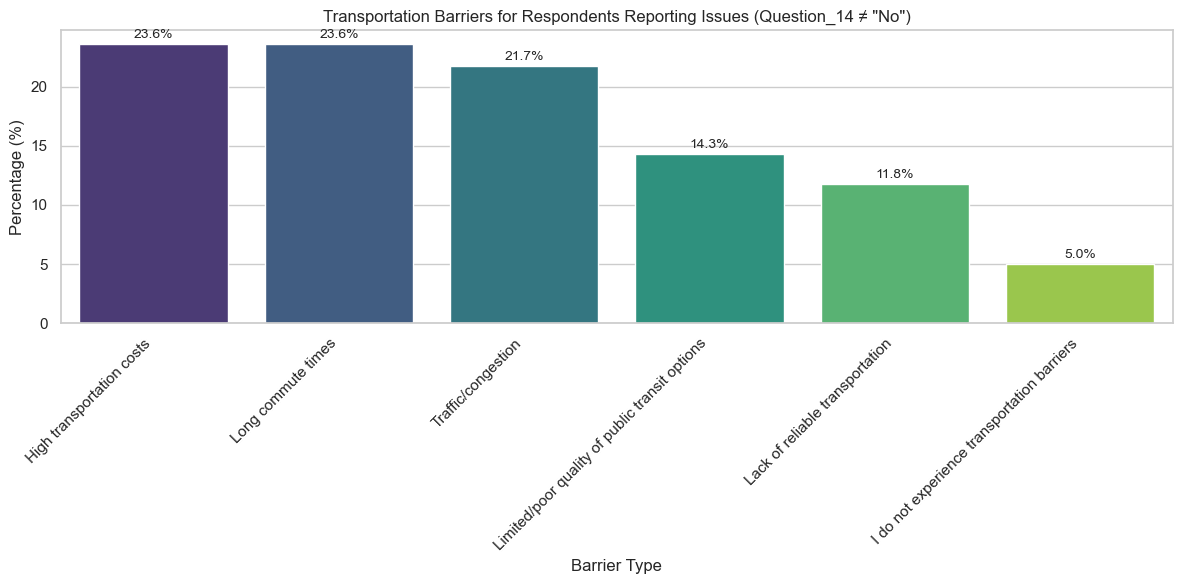

                                          Barrier  Count  Percentage
0                       High transportation costs     38   23.602484
1                              Long commute times     38   23.602484
2                              Traffic/congestion     35   21.739130
3  Limited/poor quality of public transit options     23   14.285714
4                 Lack of reliable transportation     19   11.801242
5     I do not experience transportation barriers      8    4.968944


In [83]:
# Filter respondents who did NOT choose 'No' in Question_14 and have barrier data
filtered = survey_clean[
    (survey_clean['Question_14'] != 'No, this has never happened to me') & 
    survey_clean['Question_13'].notna()
]

# Split and explode barrier responses
filtered = filtered.assign(Barrier=filtered['Question_13'].str.split(','))
filtered = filtered.explode('Barrier')
filtered['Barrier'] = filtered['Barrier'].str.strip()
filtered['Barrier'] = filtered['Barrier'].replace('Other: (please describe)', 'Other')

# Calculate barrier percentages
barrier_counts = filtered['Barrier'].value_counts().reset_index()
barrier_counts.columns = ['Barrier', 'Count']
barrier_counts['Percentage'] = (barrier_counts['Count'] / barrier_counts['Count'].sum()) * 100

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Barrier', y='Percentage', data=barrier_counts, palette='viridis')
plt.title('Transportation Barriers for Respondents Reporting Issues (Question_14 ≠ "No")')
plt.xlabel('Barrier Type')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')

# Add percentage labels
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2.,
        height + 0.5,
        f'{height:.1f}%',
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()

# Display table
print(barrier_counts.sort_values('Percentage', ascending=False))
